In [254]:
import findspark
findspark.init()
import pyspark #only run after findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "15g") \
    .appName('GrpA2') \
    .getOrCreate()
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.feature import StandardScaler, PCA
from pyspark.mllib.stat import Statistics
import numpy as np
import pandas as pd
from pprint import pprint

In [255]:
# Read the dataset
df = spark.read.csv('data.csv', header=True, inferSchema=True, quote='"', escape='"')
df.show(n=6, truncate=True)
df.printSchema()

+-------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+----------+----------+--------------------+--------------+--------------------+--------+----------+-----+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+------------+

Checking that the datatype of each column of csv file matches df after inferSchema.

At a glance, we can see that the datatype for some of the columns are "string" when they are int/floats.
As such, we took a deeper look at the values in each column, and noticed that due to "desc" and "emp title" have "," in their values. This caused the reading of the csv file to be misaligned and added string data to other columns.

Hence, we added quote='"', escape='"' to parse the quoted strings correctly when reading them in pyspark

In [256]:
from pyspark.sql.functions import when, col

#'n/a' string values to NULL
for col_name in df.columns:
    df = df.withColumn(col_name, when(col(col_name) == "n/a", None).otherwise(col(col_name)))

We noticed that there were string values "n/a" in the "emp_length" column. After further analysis, we concluded that the value "n/a" denoted NULL values. We then checked through each column to see if there were any more "n/a" string values.
Hence, we changed all "n/a" to NULL to standardise how we represent all NULL values.

In [257]:
def checkDataType(value):
    try:
        int(value)
        return "int"
    except ValueError:
        try:
            float(value)
            return "float"
        except ValueError:
            return "string"
        
print(checkDataType("1.5"))
print(checkDataType("1"))
print(checkDataType("1 a"))

float
int
string


In [258]:
df.describe().show()

+-------+--------------------+--------------------+------------------+------------------+------------------+----------+------------------+------------------+------+---------+--------------------+----------+--------------+------------------+-------------------+----------+----------+--------------------+-------+--------------------+--------+----------+------------------+-----------------+----------------+------------------+----------------------+----------------------+------------------+-------------------+-----------------+-----------------+------------------+-------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-----------------------+------------+------------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+------------------+------------------+-------------------------+--------------------+----------

We get a overview of the dataframe, such as the count, mean, standard deviation, min and max of each column. 
This gives us a better understanding of each column.

## Check for missing values

In [259]:
print(f"Total number of rows: {df.count()}")
df.summary("count").show(vertical=True)

Total number of rows: 855969
-RECORD 0-----------------------------
 summary                     | count  
 id                          | 855969 
 member_id                   | 855969 
 loan_amnt                   | 855969 
 funded_amnt                 | 855969 
 funded_amnt_inv             | 855969 
 term                        | 855969 
 int_rate                    | 855969 
 installment                 | 855969 
 grade                       | 855969 
 sub_grade                   | 855969 
 emp_title                   | 806526 
 emp_length                  | 812908 
 home_ownership              | 855969 
 annual_inc                  | 855969 
 verification_status         | 855969 
 issue_d                     | 855969 
 pymnt_plan                  | 855969 
 desc                        | 121812 
 purpose                     | 855969 
 title                       | 855936 
 zip_code                    | 855969 
 addr_state                  | 855969 
 dti                         | 8559

View the counts of each column. To see which column has missing values.
There were many columns with more than 95% missing values. Hence, we took a closer look at each of those columns to evaluate their usability.

### Display columns grouped by data types

In [260]:
# Use dtypes method to get data types of all columns
data_types = df.dtypes

# Group the columns based on their data types
grouped_types = {}
for col_name, col_type in data_types:
    if col_type not in grouped_types:
        grouped_types[col_type] = [col_name]
    else:
        grouped_types[col_type].append(col_name)

# Print the grouped columns
for data_type, columns in grouped_types.items():
    print("Data type: ", data_type)
    print("Columns: ", columns)
    print()

Data type:  int
Columns:  ['id', 'member_id', 'loan_amnt', 'funded_amnt', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'default_ind']

Data type:  double
Columns:  ['funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'revol_util', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'annual_inc_joint', 'dti_joint', 'il_util', 'all_util']

Data type:  string
Columns:  ['term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_owners

Splitting the data between int, float, and string data types to check that each column has the right data type.

### Display number of distinct values in each column

In [261]:
# Get the count of distinct values in each column
counts = [df.select(col).distinct().count() for col in df.columns]

print("Total number of unique values")
# Display the counts for each column
for i, col in enumerate(df.columns):
    print("{:<30}: {}".format(col, counts[i]))

Total number of unique values
id                            : 855969
member_id                     : 855969
loan_amnt                     : 1368
funded_amnt                   : 1368
funded_amnt_inv               : 8818
term                          : 2
int_rate                      : 520
installment                   : 67349
grade                         : 7
sub_grade                     : 35
emp_title                     : 290911
emp_length                    : 12
home_ownership                : 6
annual_inc                    : 48163
verification_status           : 3
issue_d                       : 103
pymnt_plan                    : 2
desc                          : 120336
purpose                       : 14
title                         : 60955
zip_code                      : 931
addr_state                    : 51
dti                           : 4074
delinq_2yrs                   : 29
earliest_cr_line              : 697
inq_last_6mths                : 9
mths_since_last_delinq       

Checking the total number of distinct values in each column. This helps us identify high cardinality variables during feature selection.

### Display columns with missing values

In [262]:
from pyspark.sql.functions import col, when, count, isnan

print("Columns with missing values:")
# assume "df" is your PySpark DataFrame object
missing_cols = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show(vertical=True)

Columns with missing values:
-RECORD 0-----------------------------
 id                          | 0      
 member_id                   | 0      
 loan_amnt                   | 0      
 funded_amnt                 | 0      
 funded_amnt_inv             | 0      
 term                        | 0      
 int_rate                    | 0      
 installment                 | 0      
 grade                       | 0      
 sub_grade                   | 0      
 emp_title                   | 49443  
 emp_length                  | 43061  
 home_ownership              | 0      
 annual_inc                  | 0      
 verification_status         | 0      
 issue_d                     | 0      
 pymnt_plan                  | 0      
 desc                        | 734157 
 purpose                     | 0      
 title                       | 33     
 zip_code                    | 0      
 addr_state                  | 0      
 dti                         | 0      
 delinq_2yrs                 | 0   

Closer view at the number of missing values in each column.

# Feature Selection

### Drop all columns with less than 5% of records as well as irrelevant/high cardinality columns

In [263]:
from pyspark.sql.functions import count

# create a list of columns to drop
# id is irrelevant to prediction, policy code is not useful as it only contains 1 value
# zip
cols_to_drop = ["id", "member_id", "policy_code", "grade", "zip_code", "title", "emp_title", "desc"]
# Drop all columns with <5% values present
threshold = df.count() * 0.05

# loop over all columns in the DataFrame
for col in df.columns:
    # count the number of non-null values in the column
    col_count = df.select(count(col)).collect()[0][0]
    # if the count is less than 40000, add the column to the list of columns to drop
    if col_count < threshold:
        cols_to_drop.append(col)

print("Columns to drop")
for col in cols_to_drop:
    print(col)
    
# drop the columns with counts less than 40000
df = df.drop(*cols_to_drop)

Columns to drop
id
member_id
policy_code
grade
zip_code
title
emp_title
desc
annual_inc_joint
dti_joint
verification_status_joint
open_acc_6m
open_il_6m
open_il_12m
open_il_24m
mths_since_rcnt_il
total_bal_il
il_util
open_rv_12m
open_rv_24m
max_bal_bc
all_util
inq_fi
total_cu_tl
inq_last_12m


We concluded that all columns with <5% of records as irrelevant/high cardinality columns and dropped them. zip-code and grade were dropped as well as they are similar to address
and sub grade. This is done to reduce multicollinearity in our data.

### Group columns by numerical and categorical

In [264]:
from pyspark.sql.types import IntegerType, LongType, FloatType, DoubleType
from pyspark.sql.functions import col

# get the data type of each column
column_types = dict(df.dtypes)

# separate columns by data type
numeric_columns = [c for c, t in df.dtypes if not t.startswith('string')]
categorical_columns = [c for c, t in df.dtypes if t.startswith('string')]

# print the results
print("Numeric columns: ", numeric_columns)
print("Categorical columns: ", categorical_columns)

Numeric columns:  ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'default_ind']
Categorical columns:  ['term', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'pymnt_plan', 'purpose', 'addr_state', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'application_type']


Split the data into numeric and categorical columns for further processing and visualisation.

# Imputing Missing Data

### Impute categorical and numerical data

In [265]:
from pyspark.sql.functions import mean

# Store the name and mode value for each column
mean_mode_dict = {}

for cat_col in categorical_columns:
    # Find mode for each column
    mode_value = df.groupby(cat_col).count().orderBy(
        "count", ascending=False).first()[0]
    
    print(cat_col, mode_value)
    mean_mode_dict[cat_col] = mode_value

for num_col in numeric_columns:
    # Find mean for each column
    mean_value = df.select(mean(num_col)).collect()[0][0]
    mean_mode_dict[num_col] = mean_value

pprint(mean_mode_dict)

print("Categorical Columns with missing values (before imputing):")
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(
    c) for c in categorical_columns]).show(vertical=True)

print("Numeric Columns with missing values (before imputing):")
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(
    c) for c in numeric_columns]).show(vertical=True)

df = df.fillna(mean_mode_dict)

print("Categorical Columns with missing values (after imputing):")
# assume "df" is your PySpark DataFrame object
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(
    c) for c in categorical_columns]).show(vertical=True)

print("Numeric Columns with missing values (after imputing):")
# assume "df" is your PySpark DataFrame object
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(
    c) for c in numeric_columns]).show(vertical=True)


term  36 months
sub_grade B3
emp_length 10+ years
home_ownership MORTGAGE
verification_status Source Verified
issue_d 01-10-2015
pymnt_plan n
purpose debt_consolidation
addr_state CA
earliest_cr_line 01-08-2001
initial_list_status f
last_pymnt_d 01-01-2016
next_pymnt_d 01-02-2016
last_credit_pull_d 01-01-2016
application_type INDIVIDUAL
{'acc_now_delinq': 0.004944104284150478,
 'addr_state': 'CA',
 'annual_inc': 75071.18596268093,
 'application_type': 'INDIVIDUAL',
 'collection_recovery_fee': 4.951227156942134,
 'collections_12_mths_ex_med': 0.014230418278493258,
 'default_ind': 0.05428584446399344,
 'delinq_2yrs': 0.31162109842763,
 'dti': 18.122164821389557,
 'earliest_cr_line': '01-08-2001',
 'emp_length': '10+ years',
 'funded_amnt': 14732.378304588134,
 'funded_amnt_inv': 14700.061225999756,
 'home_ownership': 'MORTGAGE',
 'initial_list_status': 'f',
 'inq_last_6mths': 0.6809148462152251,
 'installment': 436.2380718343657,
 'int_rate': 13.192319605031795,
 'issue_d': '01-10-2015',

Imputing mean for all missing values in numeric columns and 
mode for all missing values in categorical columns.

Check that all columns have been inputed with the right values (mean/mode) and that there are no more missing values.

In [266]:
from pyspark.sql.functions import col, when, count, isnan

print("Update dataframe with encoded columns:")
# assume "df" is your PySpark DataFrame object
missing_cols = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show(vertical=True)

Update dataframe with encoded columns:
-RECORD 0--------------------------
 loan_amnt                   | 0   
 funded_amnt                 | 0   
 funded_amnt_inv             | 0   
 term                        | 0   
 int_rate                    | 0   
 installment                 | 0   
 sub_grade                   | 0   
 emp_length                  | 0   
 home_ownership              | 0   
 annual_inc                  | 0   
 verification_status         | 0   
 issue_d                     | 0   
 pymnt_plan                  | 0   
 purpose                     | 0   
 addr_state                  | 0   
 dti                         | 0   
 delinq_2yrs                 | 0   
 earliest_cr_line            | 0   
 inq_last_6mths              | 0   
 mths_since_last_delinq      | 0   
 mths_since_last_record      | 0   
 open_acc                    | 0   
 pub_rec                     | 0   
 revol_bal                   | 0   
 revol_util                  | 0   
 total_acc               

## Bar chart showing distribution of default_ind values

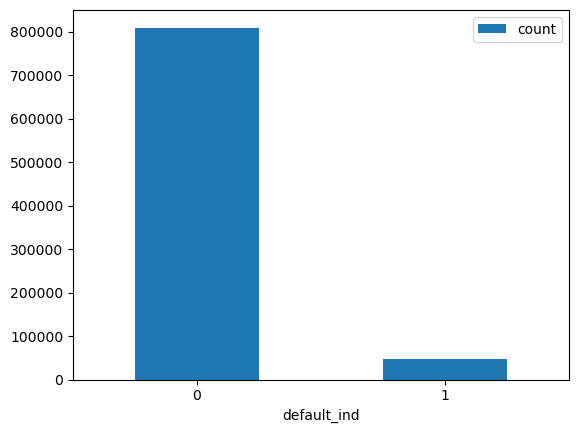

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# assume 'df' is a PySpark DataFrame
value_counts = df.groupBy('default_ind').count().orderBy(
    'count', ascending=False)

# convert to Pandas DataFrame and plot bar chart
pd_value_counts = value_counts.toPandas()
pd_value_counts.plot.bar(x='default_ind', y='count', rot=0)
plt.show()


Very skewed distribution of label column where there are a lot more default_ind = 0 than default_ind = 1. 

## Density Plot against default_ind

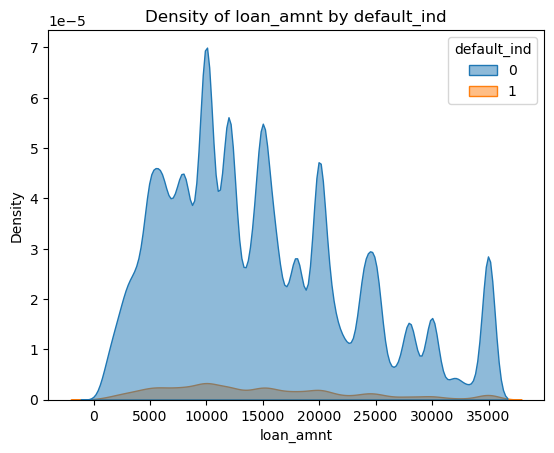

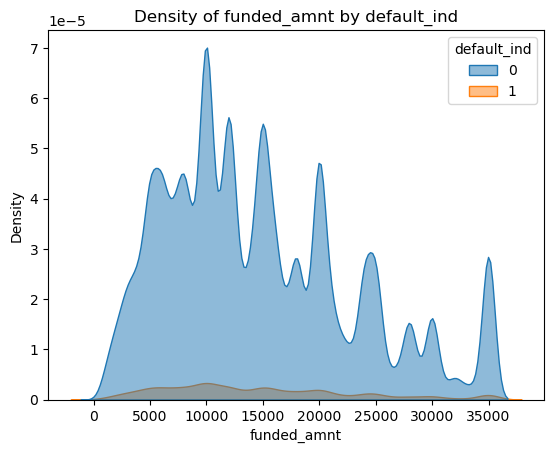

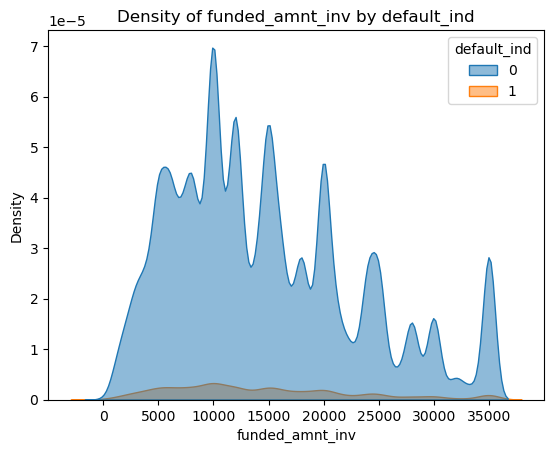

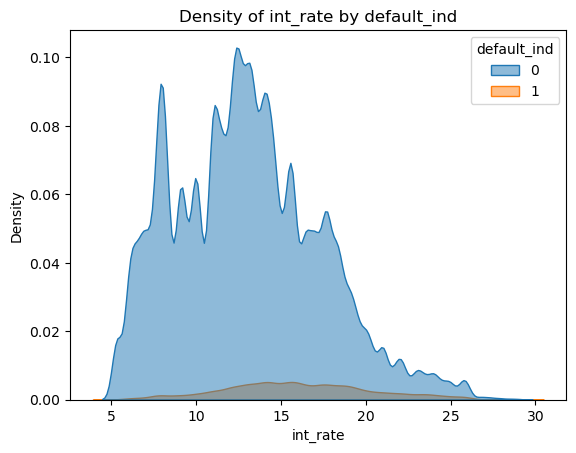

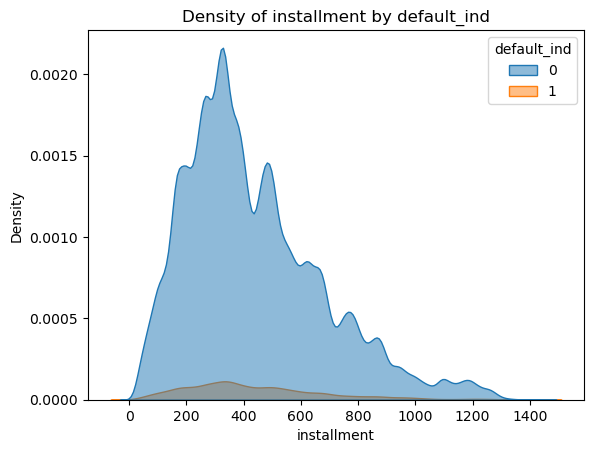

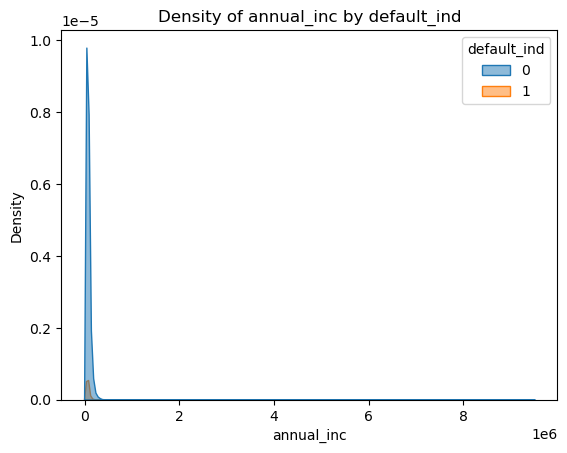

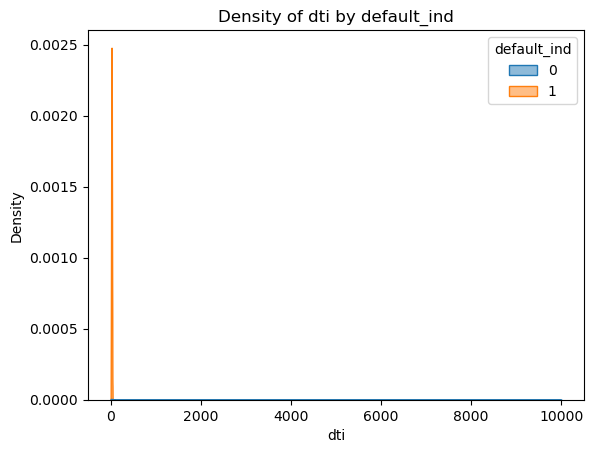

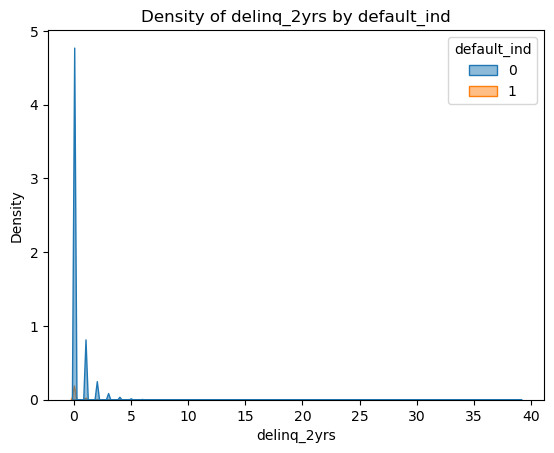

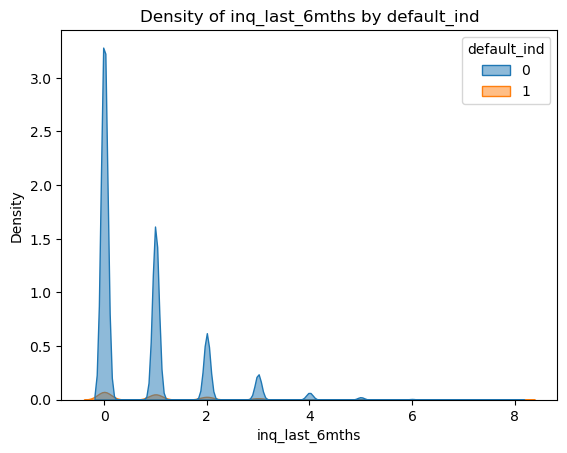

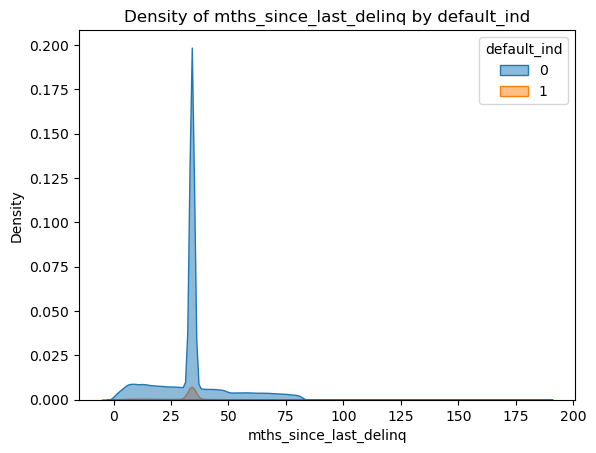

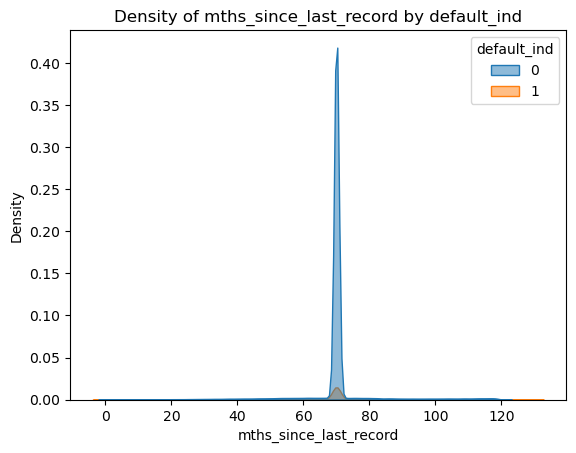

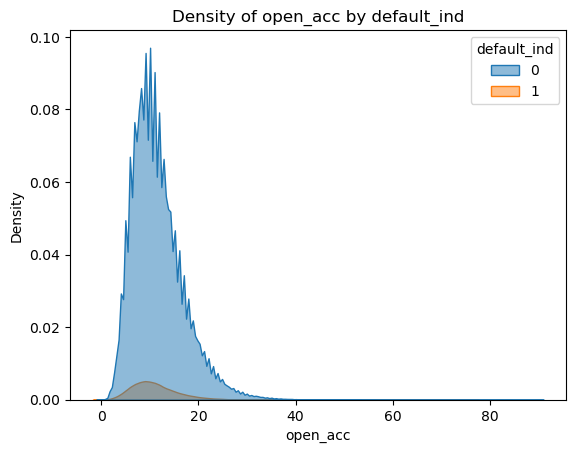

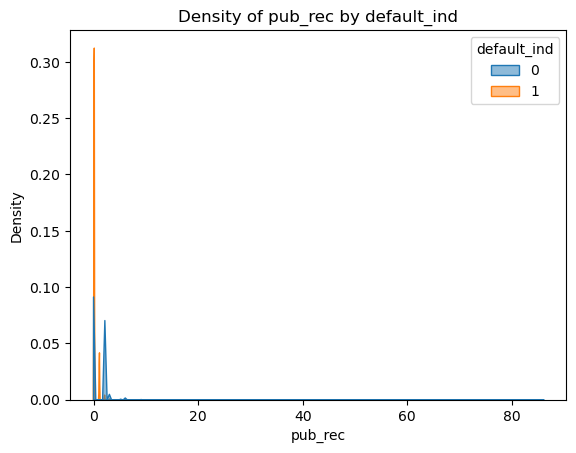

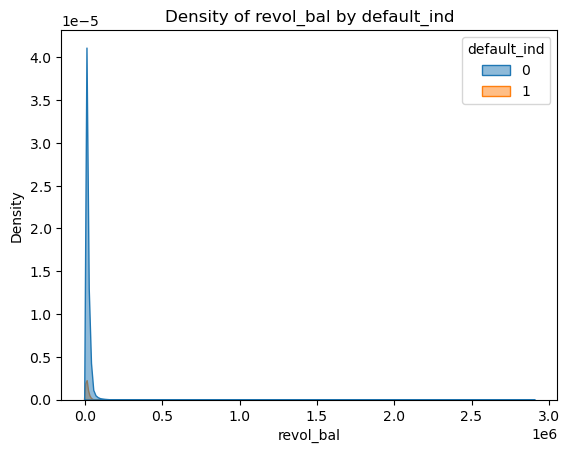

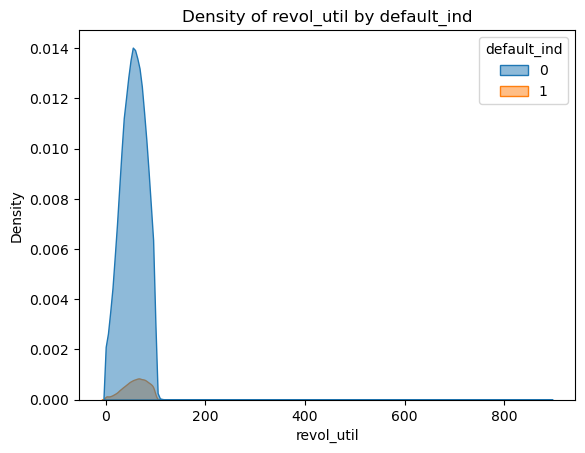

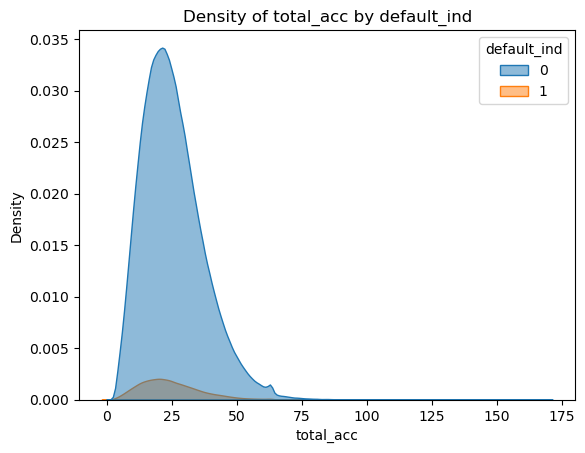

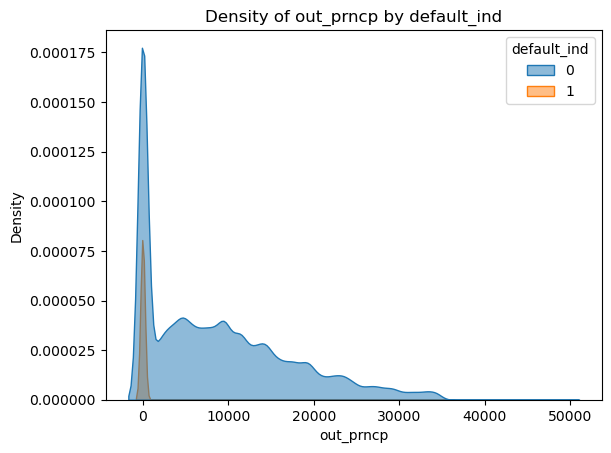

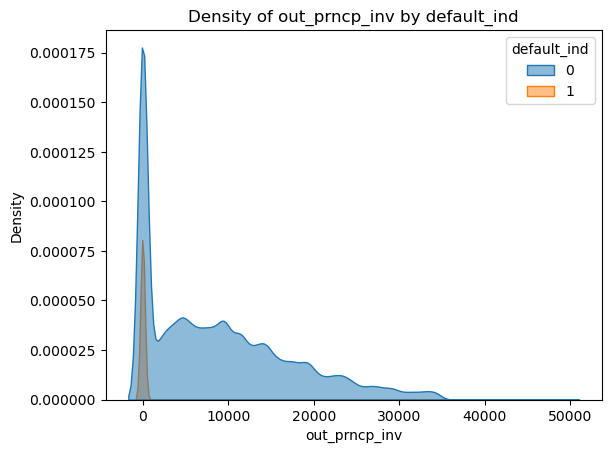

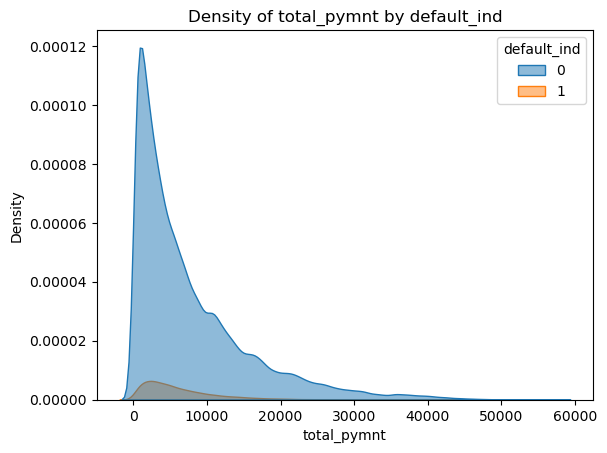

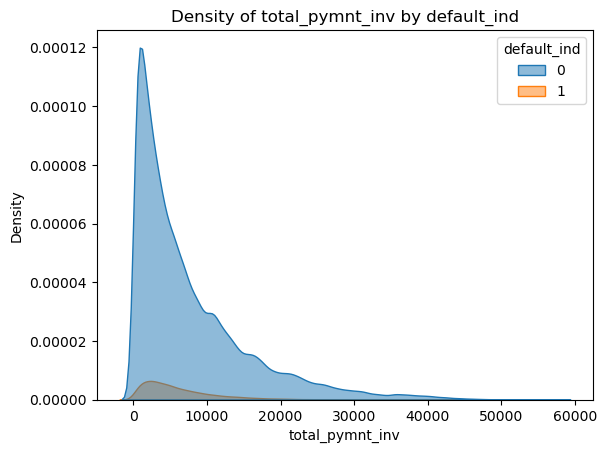

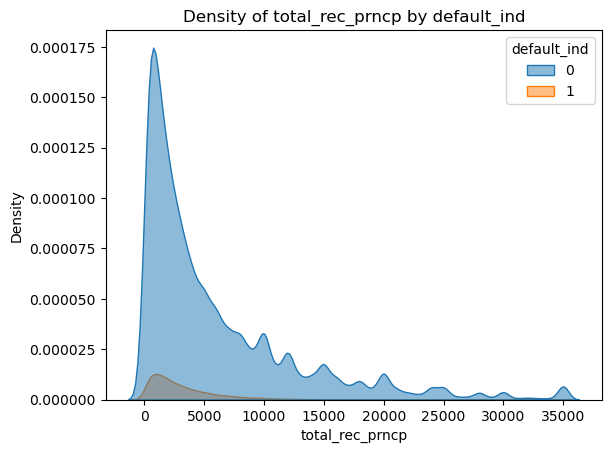

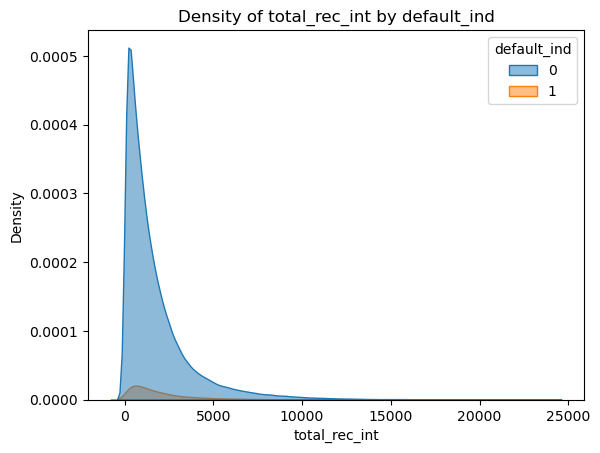

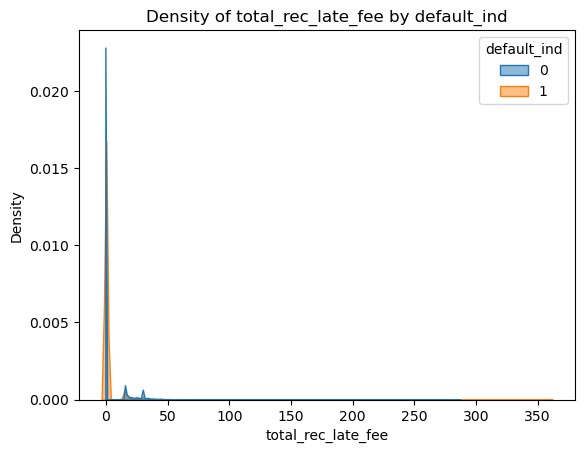

c:\Users\Vokur\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


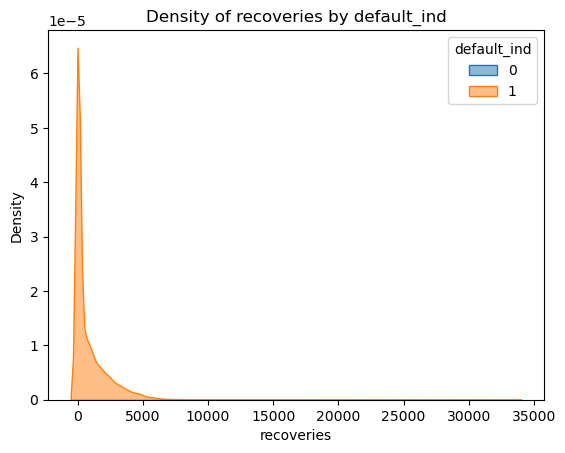

c:\Users\Vokur\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


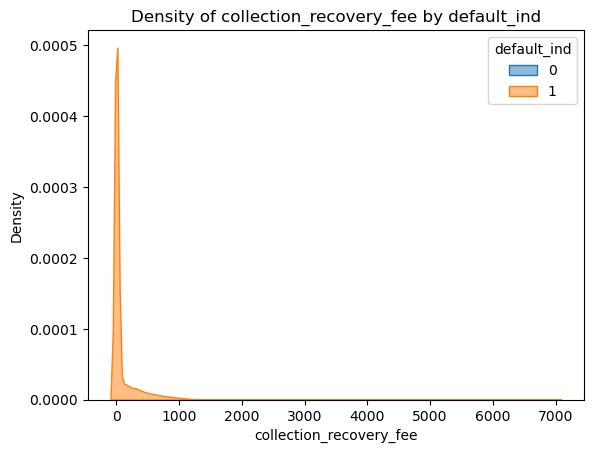

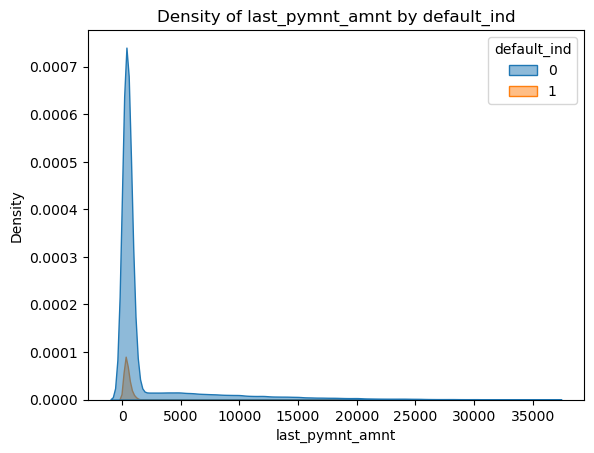

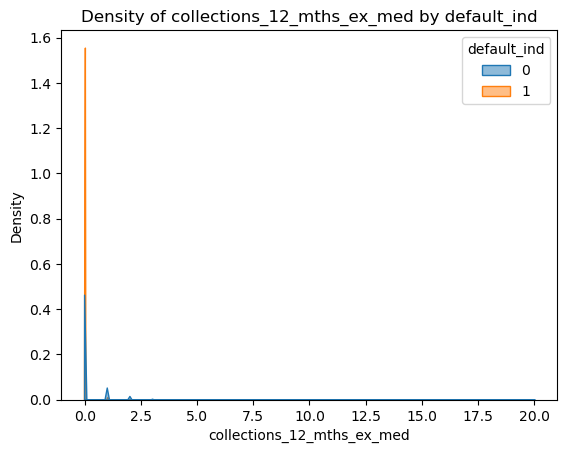

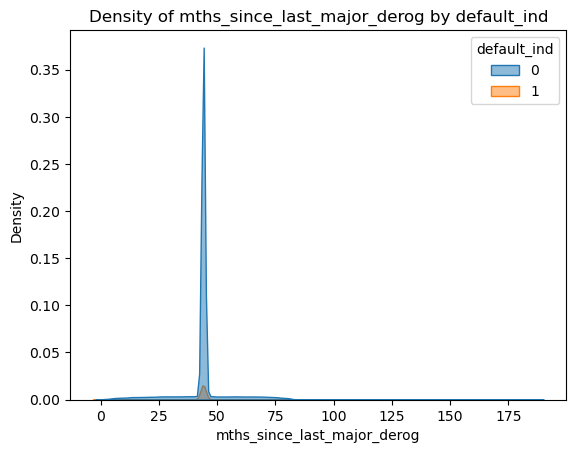

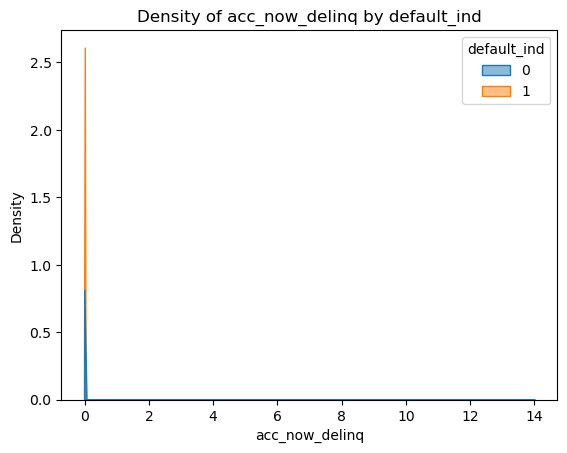

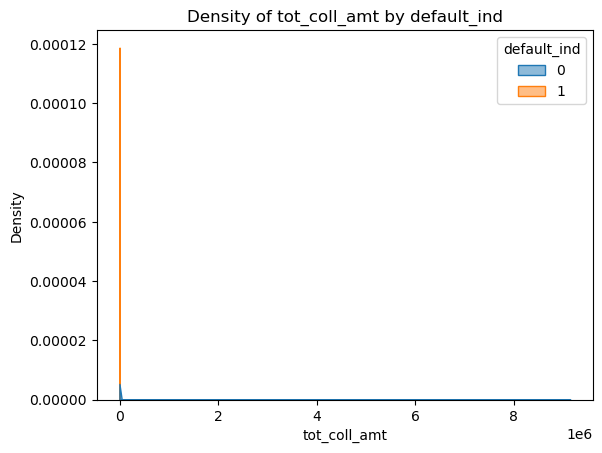

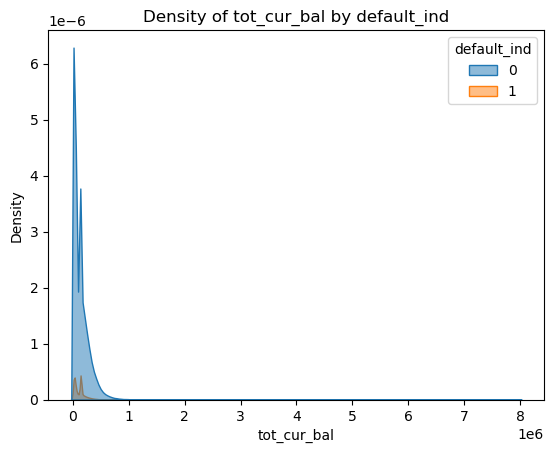

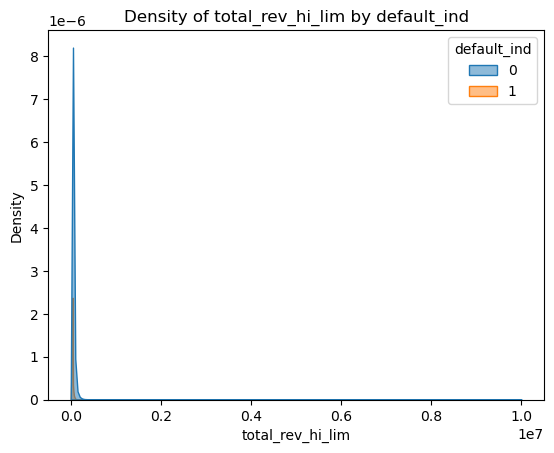

c:\Users\Vokur\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


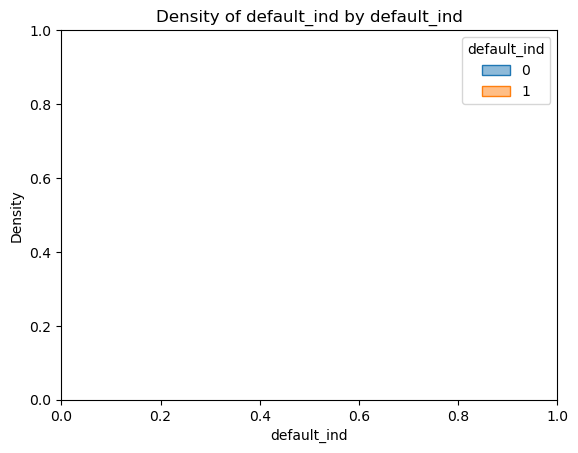

In [267]:
import matplotlib.pyplot as plt
import seaborn as sns

# Iterate through the five airlines
df_numeric = df.select(numeric_columns)

df_numericPanda = df_numeric.toPandas()

for col in df_numericPanda:
    # Create a density plot with Seaborn
    sns.kdeplot(data=df_numericPanda, x=col, hue='default_ind', fill=True, alpha=0.5)

    # Set the plot title
    plt.title(f"Density of {col} by default_ind")
    
    # Show the plot
    plt.show()

Viewing the distribution of numeric data for each default_ind value.
Generally, most of the features have a much higher density when default_ind is 0.

Some exceptions are pub_rec, collections_12_mths_ex_med, acc_now_delinq, tot_coll_amt, dti. i.e. For dti, the density for default_ind = 0 are at mostly 0.

There are some features that are only applicable when default_ind is 1. i.e. recoveries, collection_recovery_feen

## Box Plot against default_ind

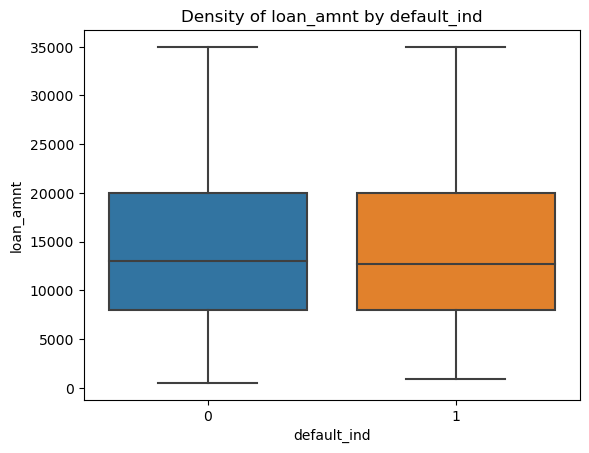

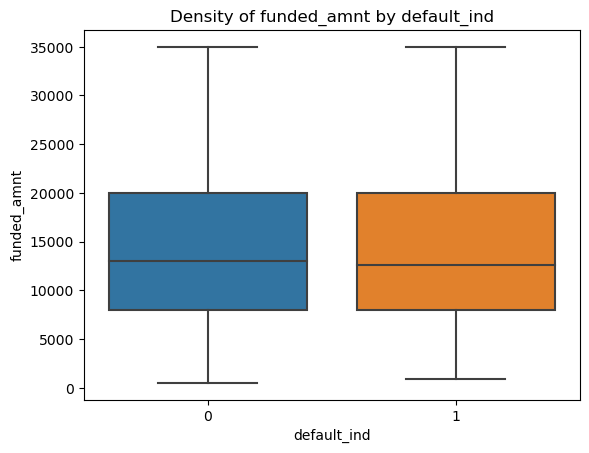

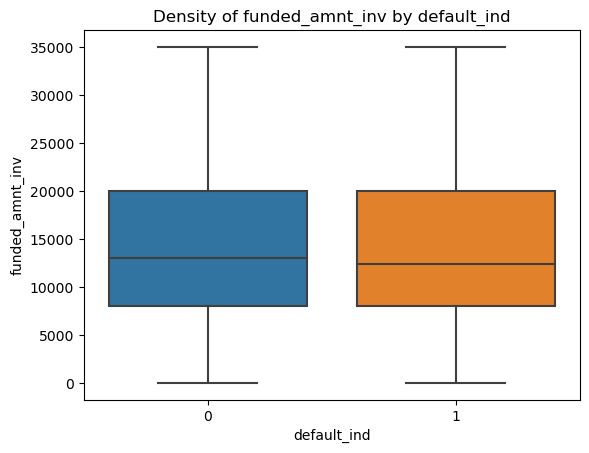

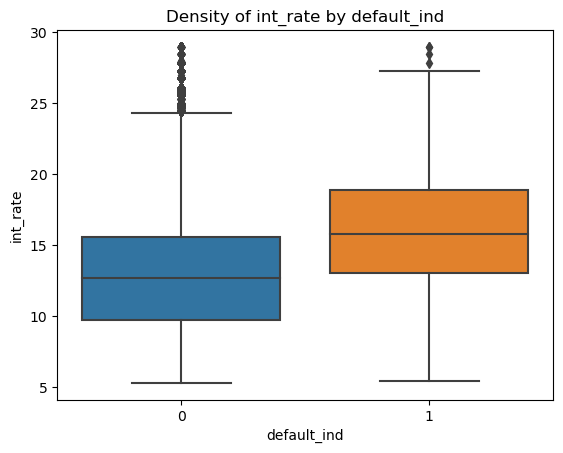

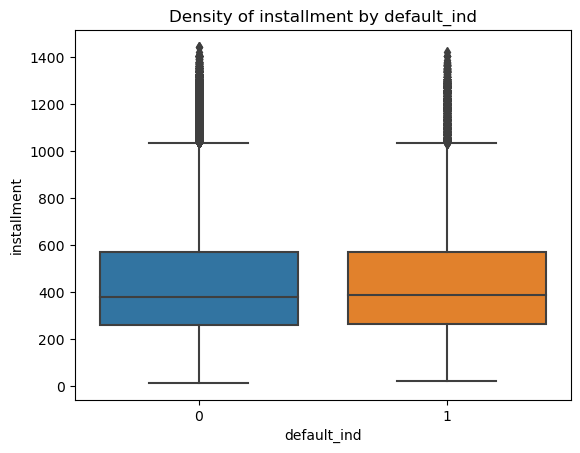

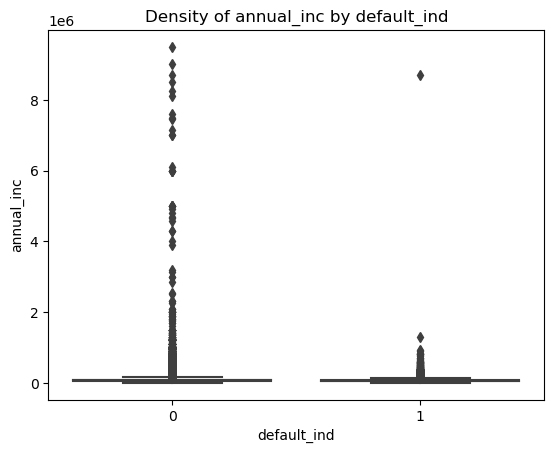

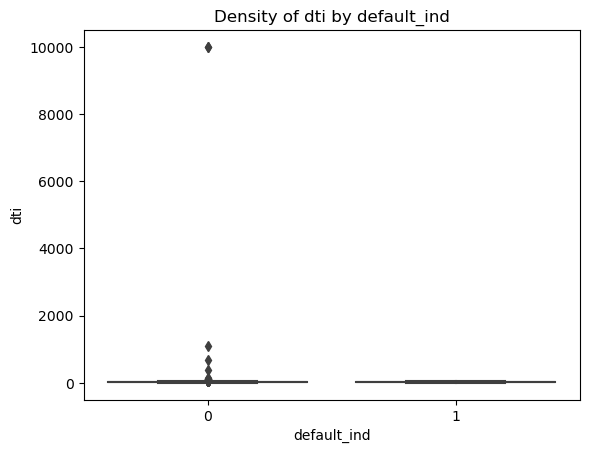

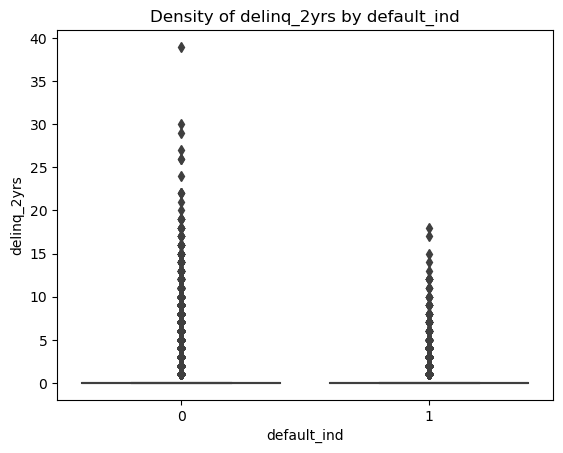

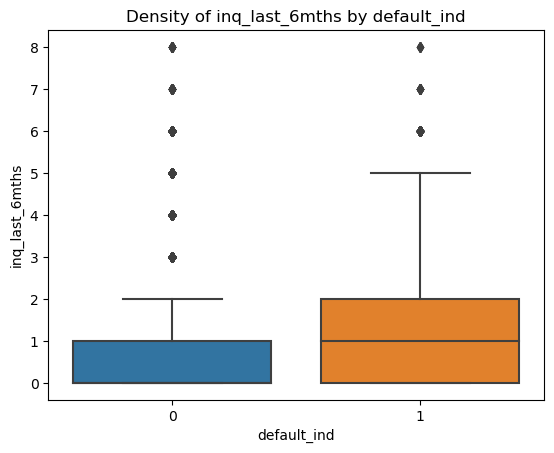

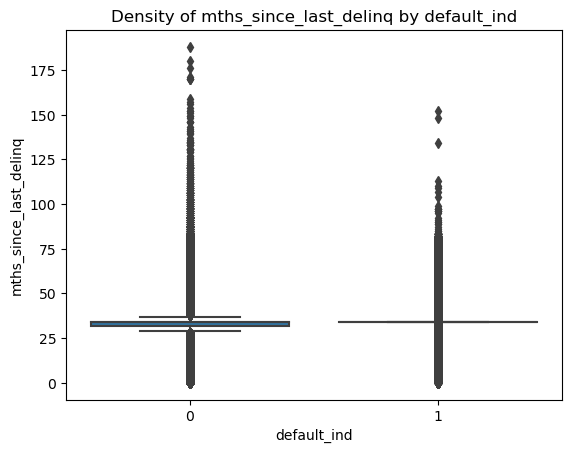

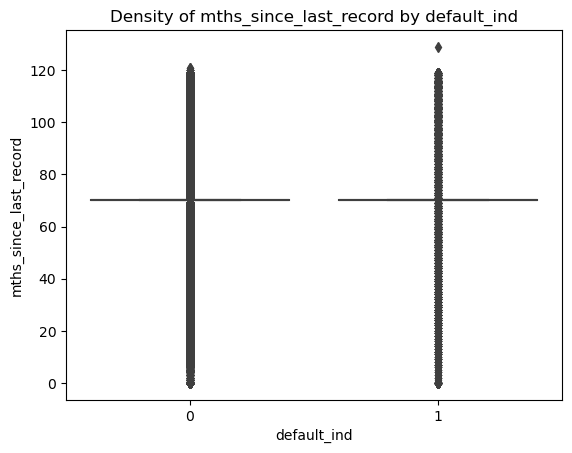

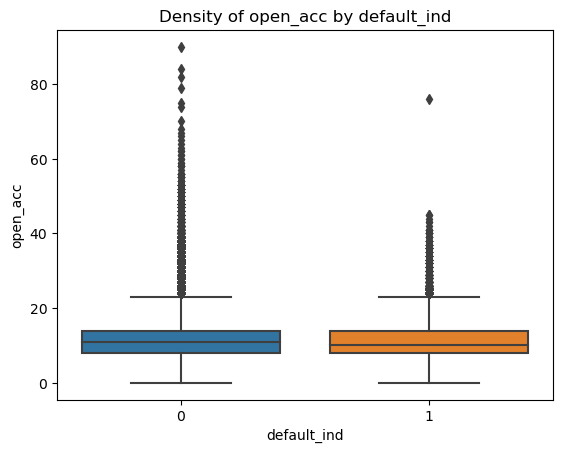

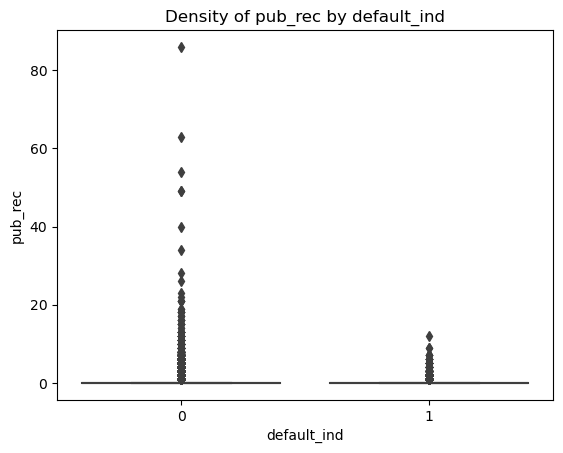

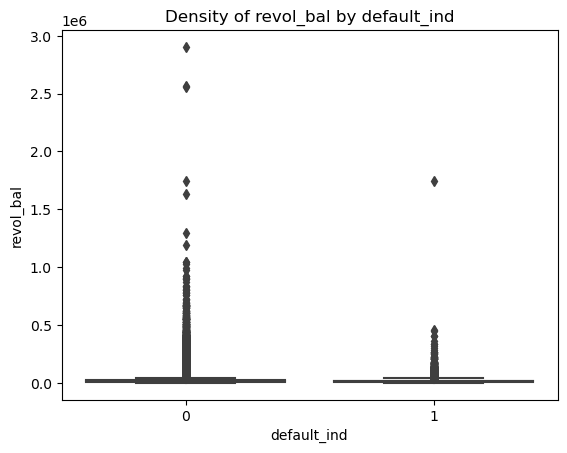

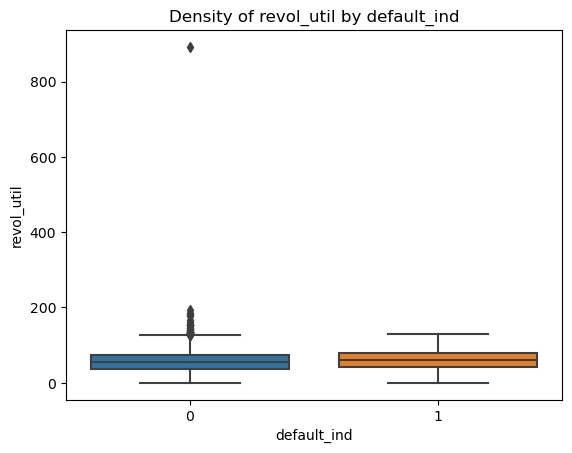

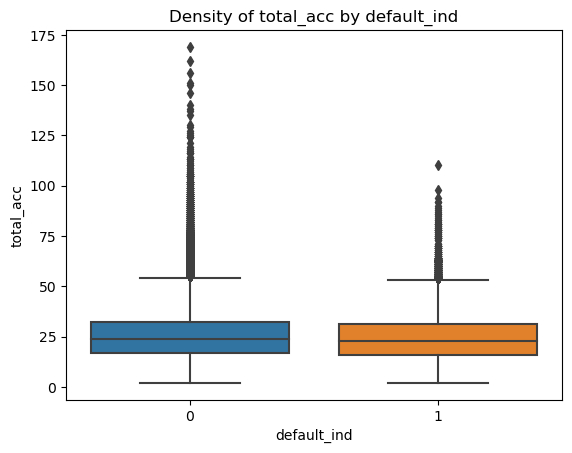

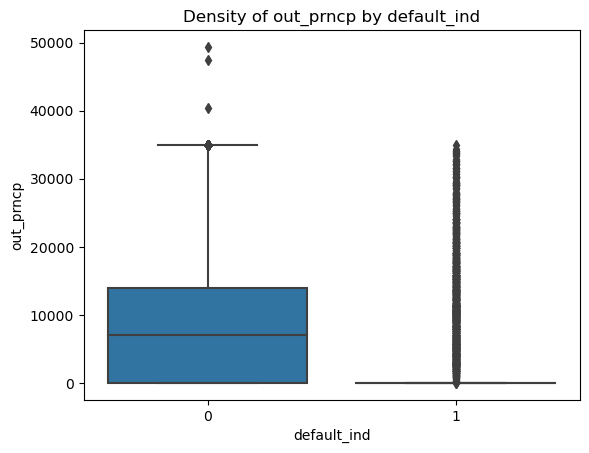

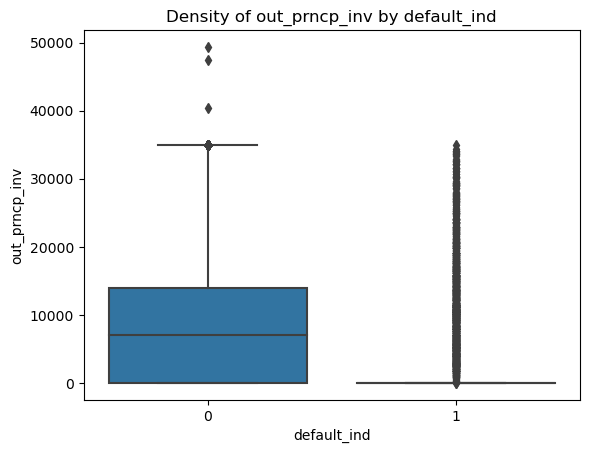

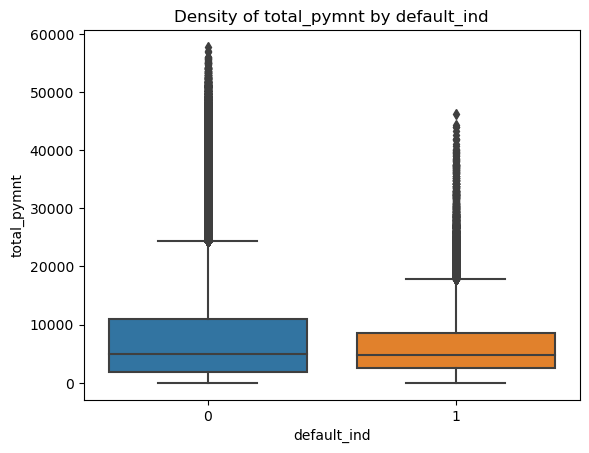

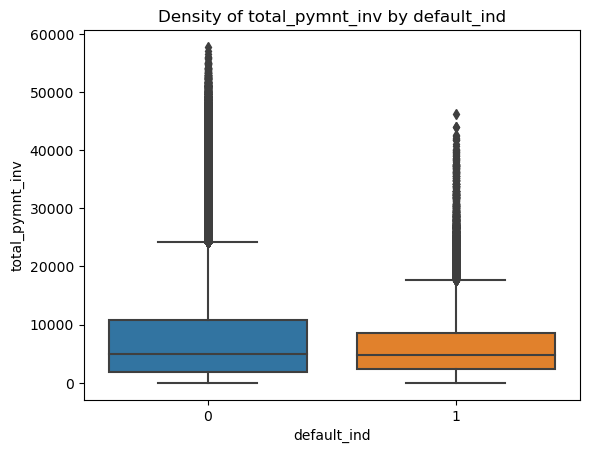

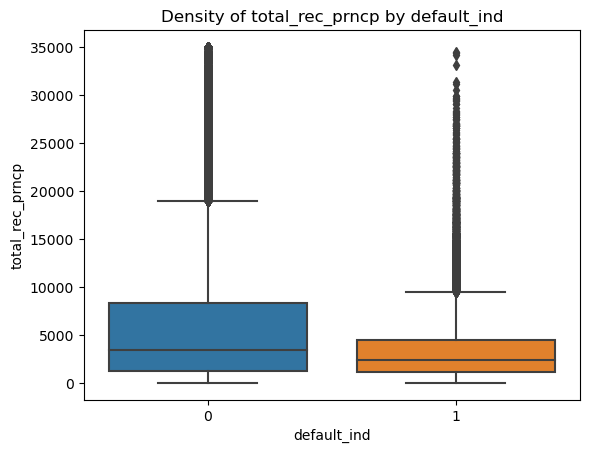

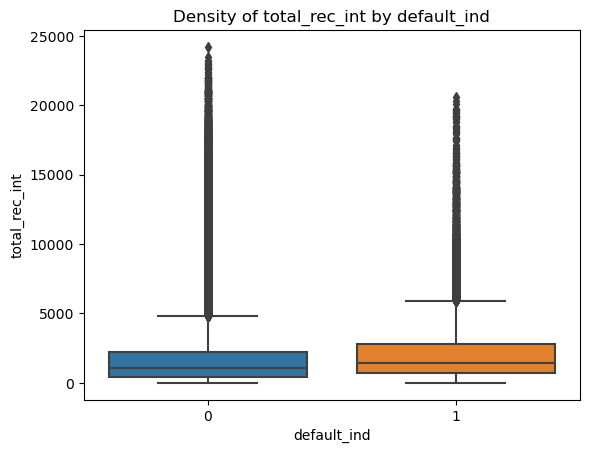

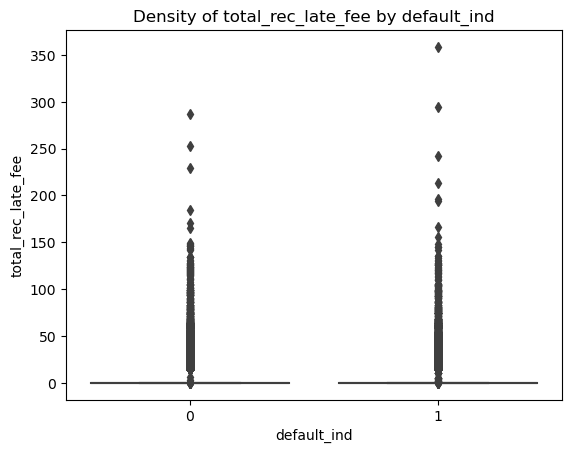

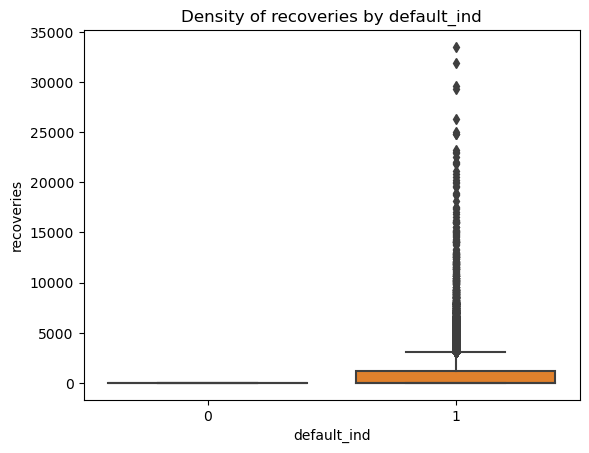

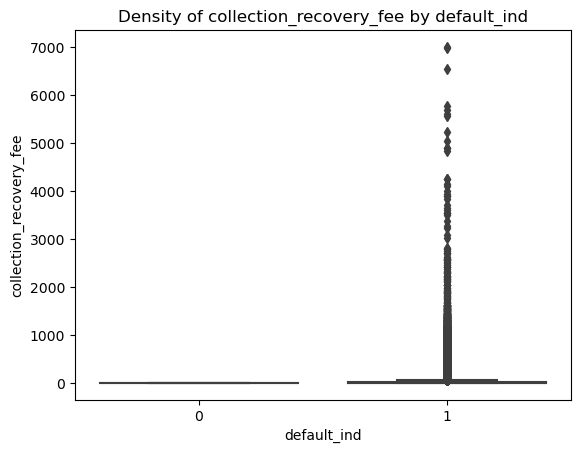

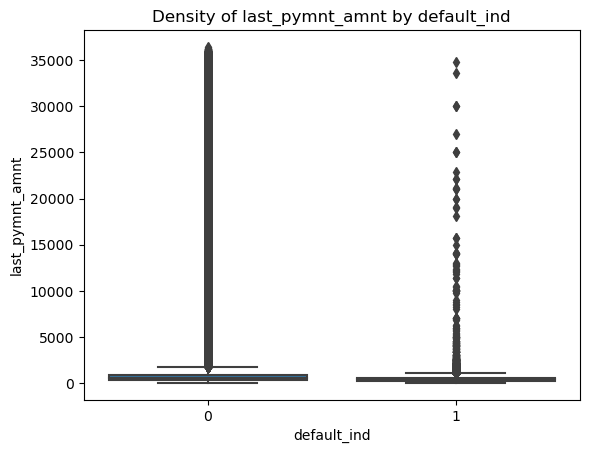

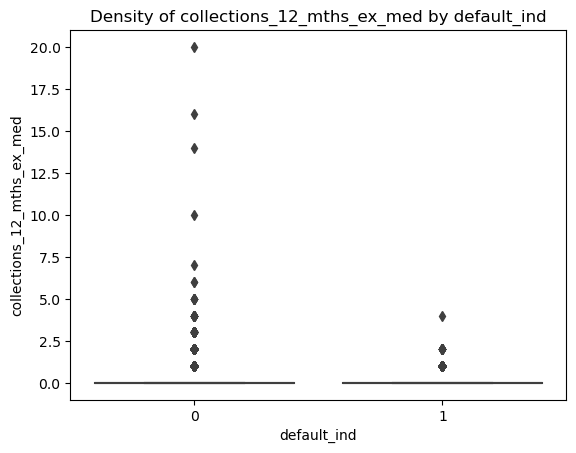

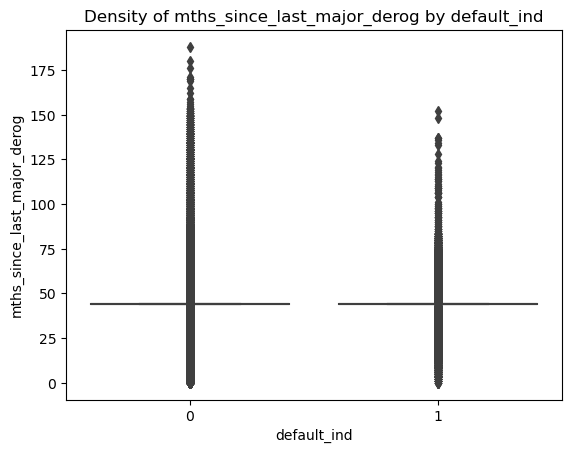

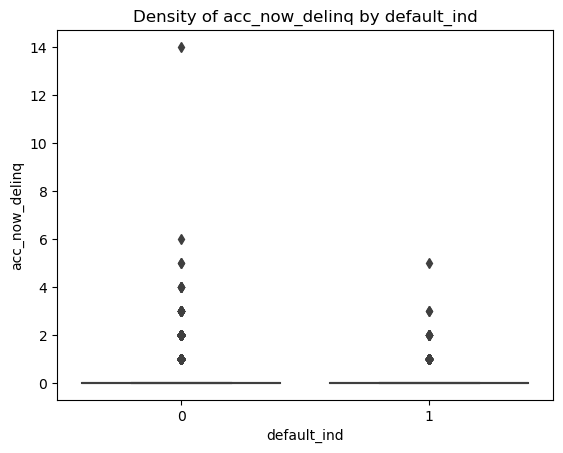

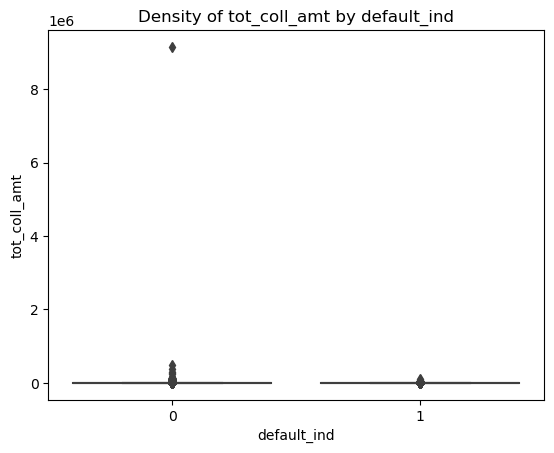

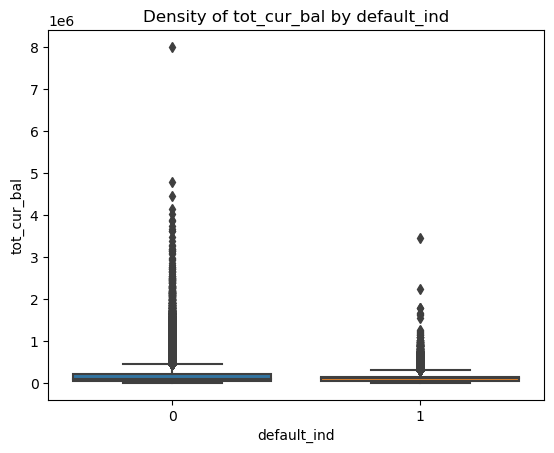

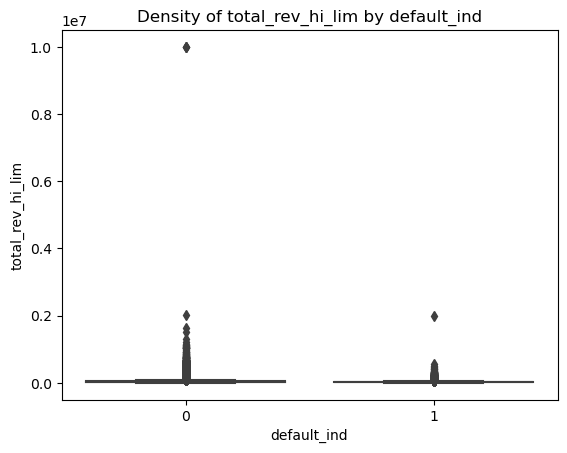

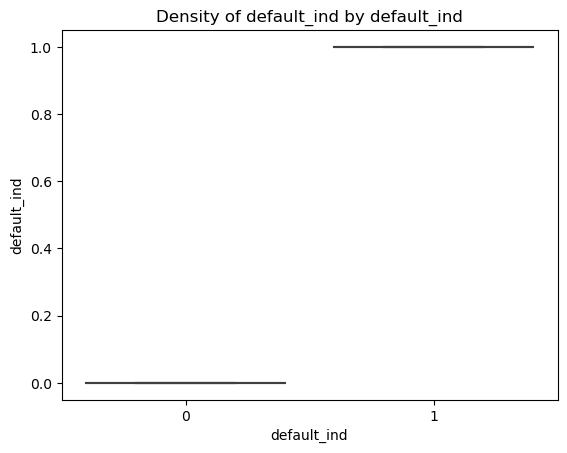

In [ ]:
# Box Plot against default_ind
df_numeric = df.select(numeric_columns)

df_numericPanda = df_numeric.toPandas()

for col in df_numericPanda:
    # Create a density plot with Seaborn
    sns.boxplot(data=df_numericPanda, x='default_ind', y=col)

    # Set the plot title
    plt.title(f"Density of {col} by default_ind")
    
    # Show the plot
    plt.show()

loan_amnt, funded_amnt, funded_amnt_inv, installment has a long tail distribution with the median closer to the head. Hence, most of the data is concentrated towards the lower end of the distribution.

int_rate has a long tail distribution with the median closer to the tail. Hence, most of the data is concentrated towards the upper end of the distribution.

## Distribution of all Categorical Features

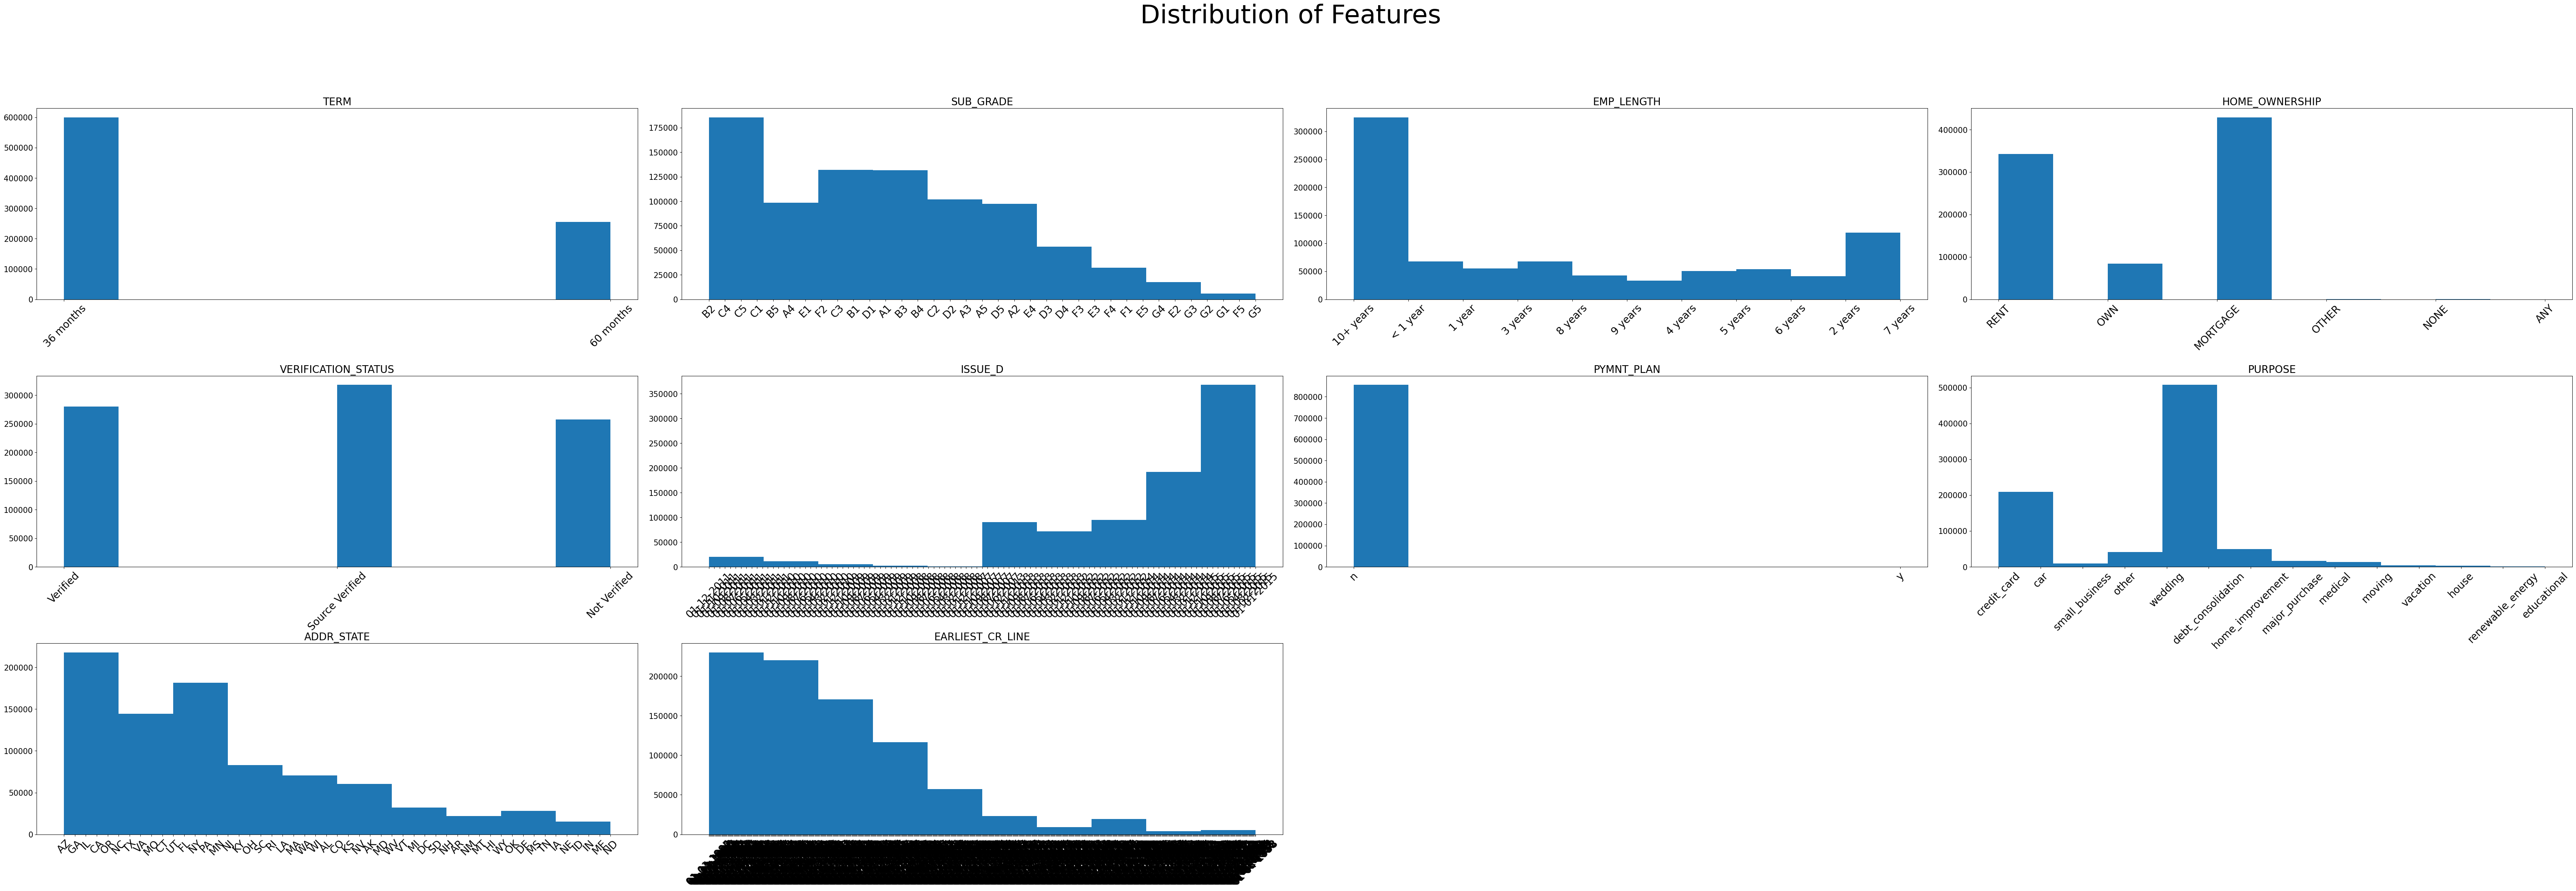

In [ ]:
df_categorical = df.select(categorical_columns)

fig = plt.figure(figsize=(70,25))
st = fig.suptitle("Distribution of Features", fontsize=50, verticalalignment='center')

for col,num in zip(df_categorical.toPandas().describe().columns, range(1,11)):
    ax = fig.add_subplot(3,4, num)
    ax.hist(df_categorical.toPandas() [col])
    plt.grid (False)
    plt.xticks (rotation=45, fontsize=20)
    plt.yticks (fontsize=15)
    plt.title(col.upper(), fontsize=20)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85, hspace = 0.4)
plt.show()

Most of the categorical features are heavily skewed, and may cause bias towards the more prevalent values.

## Heatmap for Categorical Features

In [ ]:
# Extract list of column names from PySpark DataFrame object
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
numeric_cols = numeric_columns.columns

# Concatenate with target column
num_cols = numeric_cols

# Convert PySpark DataFrame to Pandas DataFrame for plotting with seaborn
df_num = df.select(num_cols).toPandas()

df_num["default_ind"] = df_num["default_ind"]

# Create pairplot
sns.pairplot(df_num, hue="default_ind", diag_kind="hist")
df_categorical = df.select(categorical_columns)

fig = plt.figure(figsize=(25, 15))
st = fig.suptitle("Heatmap of Categorical Features",
                  fontsize=50, verticalalignment='center')

for col, num in zip(df_categorical.toPandas().describe().columns, range(1, 11)):
    ax = fig.add_subplot(3, 4, num)
    ax.hist(df_categorical.toPandas()[col])
    plt.grid(False)
    plt.xticks(rotation=45, fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(), fontsize=20)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85, hspace=0.4)
plt.show()

# Convert PySpark DataFrame to Pandas DataFrame
df_pd = numeric_columns.toPandas()

# Get the correlation matrix
corr_matrix = df_pd.corr()

# Create a heatmap of the correlation matrix
sns.heatmap(corr_matrix, cmap="YlGnBu")

# Show the plot
plt.show()


## Heatmap for numerical features

In [ ]:
# Convert PySpark DataFrame to Pandas DataFrame
df_pd = numeric_columns.toPandas()

# Fill missing values with the mean
df_pd = df_pd.fillna(df_pd.mean())

# Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_pd)

# Convert the scaled data back to a Pandas DataFrame
df_scaled = pd.DataFrame(scaled_data, columns=df_pd.columns)

# Get the correlation matrix
corr_matrix = df_scaled.corr()

# Create a heatmap of the correlation matrix
sns.heatmap(corr_matrix, cmap="YlGnBu")

# Show the plot
plt.show()


### One hot encoding for categorical columns

In [ ]:
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

# List of columns to one-hot encode
cat_cols = [c for c in categorical_columns if c not in ['sub_grade', 'grade', 'emp_length']]

# StringIndexer for each categorical column
indexers = [StringIndexer(inputCol=c, outputCol=c+'_index', handleInvalid='keep')
            for c in cat_cols]

# OneHotEncoderEstimator for each categorical column
encoders = [OneHotEncoder(inputCols=[c+'_index'], outputCols=[c+'_encoded'])
            for c in cat_cols]

# Pipeline for the string indexer and one-hot encoder
stages = indexers + encoders
pipeline = Pipeline(stages=stages)


df_categorical = df.alias("df_categorical")

# Fit the pipeline to the data
model = pipeline.fit(df_categorical)
encoded_df = model.transform(df_categorical)

# Drop the original categorical columns that have been one-hot encoded
encoded_df = encoded_df.drop(*cat_cols)
encoded_df = encoded_df.drop(*[c+"_index" for c in cat_cols])
# Print the schema of the encoded DataFrame
encoded_df.printSchema()



root
 |-- loan_amnt: integer (nullable = true)
 |-- funded_amnt: integer (nullable = true)
 |-- funded_amnt_inv: double (nullable = false)
 |-- int_rate: double (nullable = false)
 |-- installment: double (nullable = false)
 |-- sub_grade: string (nullable = false)
 |-- emp_length: string (nullable = false)
 |-- annual_inc: double (nullable = false)
 |-- dti: double (nullable = false)
 |-- delinq_2yrs: integer (nullable = true)
 |-- inq_last_6mths: integer (nullable = true)
 |-- mths_since_last_delinq: integer (nullable = true)
 |-- mths_since_last_record: integer (nullable = true)
 |-- open_acc: integer (nullable = true)
 |-- pub_rec: integer (nullable = true)
 |-- revol_bal: integer (nullable = true)
 |-- revol_util: double (nullable = false)
 |-- total_acc: integer (nullable = true)
 |-- out_prncp: double (nullable = false)
 |-- out_prncp_inv: double (nullable = false)
 |-- total_pymnt: double (nullable = false)
 |-- total_pymnt_inv: double (nullable = false)
 |-- total_rec_prncp: d

In [ ]:
encoded_df.show(2)

+---------+-----------+---------------+--------+-----------+---------+----------+----------+-----+-----------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------------+---------------------------+--------------+------------+-----------+----------------+-----------+-------------+----------------------+---------------------------+----------------+------------------+---------------+------------------+------------------------+---------------------------+--------------------+--------------------+--------------------------+------------------------+
|loan_amnt|funded_amnt|funded_amnt_inv|int_rate|installment|sub_grade|emp_length|annual_inc|  dti|delinq_2yrs|inq_last_6mths|mths_since_last_delinq|mths_since_last_record|open_acc|pub_rec|revol_bal|revol_util|total_acc|ou

In [ ]:
encoded_df.select("last_pymnt_d_encoded").show()

+--------------------+
|last_pymnt_d_encoded|
+--------------------+
|     (97,[12],[1.0])|
|     (97,[34],[1.0])|
|     (97,[19],[1.0])|
|     (97,[12],[1.0])|
|      (97,[0],[1.0])|
|     (97,[12],[1.0])|
|      (97,[0],[1.0])|
|     (97,[12],[1.0])|
|     (97,[46],[1.0])|
|     (97,[39],[1.0])|
|     (97,[33],[1.0])|
|     (97,[29],[1.0])|
|     (97,[42],[1.0])|
|     (97,[12],[1.0])|
|     (97,[26],[1.0])|
|     (97,[12],[1.0])|
|     (97,[12],[1.0])|
|     (97,[31],[1.0])|
|     (97,[11],[1.0])|
|     (97,[42],[1.0])|
+--------------------+
only showing top 20 rows



One-Hot Encoded all categorical data except sub_grade, grade, emp_length.

### Ordinal encoding for grade, sub_grade, emp_length columns

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

encoded_df = encoded_df.withColumn("emp_length_encoded",
                                   when((encoded_df.emp_length == "< 1 year"), 0.0).
                                   when((encoded_df.emp_length == "1 year"), 1.0).
                                   when((encoded_df.emp_length == "2 years"), 2.0).
                                   when((encoded_df.emp_length == "3 years"), 3.0).
                                   when((encoded_df.emp_length == "4 years"), 4.0).
                                   when((encoded_df.emp_length == "5 years"), 5.0).
                                   when((encoded_df.emp_length == "6 years"), 6.0).
                                   when((encoded_df.emp_length == "7 years"), 7.0).
                                   when((encoded_df.emp_length == "8 years"), 8.0).
                                   when((encoded_df.emp_length == "9 years"), 9.0).
                                   when((encoded_df.emp_length == "10+ years"), 10.0))

indexers = [
    # StringIndexer(inputCol="grade", outputCol="grade_encoded", stringOrderType = "alphabetAsc"),
    StringIndexer(inputCol='sub_grade', outputCol='sub_grade_encoded', stringOrderType = "alphabetAsc")
]

pipeline = Pipeline(stages=indexers)
encoded_df = pipeline.fit(encoded_df).transform(encoded_df)

encoded_df = encoded_df.drop("grade", "sub_grade", "emp_length")

encoded_df.printSchema()

root
 |-- loan_amnt: integer (nullable = true)
 |-- funded_amnt: integer (nullable = true)
 |-- funded_amnt_inv: double (nullable = false)
 |-- int_rate: double (nullable = false)
 |-- installment: double (nullable = false)
 |-- annual_inc: double (nullable = false)
 |-- dti: double (nullable = false)
 |-- delinq_2yrs: integer (nullable = true)
 |-- inq_last_6mths: integer (nullable = true)
 |-- mths_since_last_delinq: integer (nullable = true)
 |-- mths_since_last_record: integer (nullable = true)
 |-- open_acc: integer (nullable = true)
 |-- pub_rec: integer (nullable = true)
 |-- revol_bal: integer (nullable = true)
 |-- revol_util: double (nullable = false)
 |-- total_acc: integer (nullable = true)
 |-- out_prncp: double (nullable = false)
 |-- out_prncp_inv: double (nullable = false)
 |-- total_pymnt: double (nullable = false)
 |-- total_pymnt_inv: double (nullable = false)
 |-- total_rec_prncp: double (nullable = false)
 |-- total_rec_int: double (nullable = false)
 |-- total_rec

In [ ]:
encoded_df.show(5)

+---------+-----------+---------------+--------+-----------+----------+-----+-----------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------------+---------------------------+--------------+------------+-----------+----------------+-----------+-------------+----------------------+---------------------------+----------------+------------------+---------------+------------------+------------------------+---------------------------+--------------------+--------------------+--------------------------+------------------------+------------------+-----------------+
|loan_amnt|funded_amnt|funded_amnt_inv|int_rate|installment|annual_inc|  dti|delinq_2yrs|inq_last_6mths|mths_since_last_delinq|mths_since_last_record|open_acc|pub_rec|revol_bal|revol_util|total_acc|out_prn

As sub_grade', 'emp_length' have ordinal relationships, we ordinally encode them so as to not lose that relationship.
Set stringOrderType to alphabetAsc as we want the Indexer to compare the values by alphabetical order instead of Frequency.

For emp_length, we cannot use the string indexer as 10 will be considered <2, as it starts with '1'.
There is also the symbol <. in < 1 year. Hence, this value will be mapped to the last order if we use StringIndexer.
As such, we manually encoded the values for emp_length.

### Check correlation between target and features

In [272]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

target_col = "default_ind"


def get_categorical_correlations(df, categorical_cols, target_col):
    # Drop all columns that are not categorical or the target
    categorical_cols = [c for c in categorical_cols if c in df.columns]
    df = df.select([c for c in categorical_cols] + [target_col])
    # Encode the target as a numerical column
    df = df.withColumn("target", col(target_col).cast("double"))
    categorical_cols.append("target")
    # Vectorize the categorical features
    assembler = VectorAssembler(
        inputCols=categorical_cols, outputCol="vector")
    df = assembler.transform(df)
    # Compute the correlation between each categorical feature and the target
    corr_matrix = Correlation.corr(df, "vector", "pearson").collect()[0][0]
    corr_array = corr_matrix.toArray()[-1, :-1]
    # Return a dictionary mapping each categorical feature to its correlation with the target
    return {categorical_cols[i]: abs(corr_array[i]) for i in range(len(categorical_cols))}


def get_numeric_correlations(df, numeric_cols, target_col):
    numeric_correlations = {}
    # Loop through all the columns in the DataFrame
    for column in numeric_cols:
        # Select the rows where a value is present for the column
        # Calculate the correlation between the column and the class column
        correlation = abs(df.corr(target_col, column))

        # Add the column name and its correlation to the dictionary
        numeric_correlations[column] = correlation
    return numeric_correlations


Most of the features have a extremely low correlation(0.0004 - 0.05) with default_ind. 

However, there are some features with a relatively high correlation with default_ind such as
recoveries: 0.475
collection_recovery_fee: 0.33
out_prncp: 0.22

In [276]:
# Define the name of the class column
class_column = "default_ind"

# Define the name of the encoded categorical columns
encoded_categorical_columns = [c + "_encoded" for c in categorical_columns]

# Define the number of top features to select
k = 5
# Get the correlations between categorical features and the target
cat_corr = get_categorical_correlations(
    encoded_df, encoded_categorical_columns, class_column)
num_corr = get_numeric_correlations(encoded_df, numeric_columns, class_column)
# Combine the correlations for all features
all_corr = {**cat_corr, **num_corr}

pprint(sorted(
    all_corr.items(), key=lambda x: x[1], reverse=True))
# Sort the correlations in descending order and select the top k features
selected_features = [f for f, c in sorted(
    all_corr.items(), key=lambda x: x[1], reverse=True)]


[('default_ind', 1.0),
 ('recoveries', 0.4757380487478789),
 ('collection_recovery_fee', 0.33076433645338876),
 ('out_prncp', 0.22596004107318401),
 ('out_prncp_inv', 0.22595893812350784),
 ('int_rate', 0.1550370700559012),
 ('total_rec_late_fee', 0.14076021198474056),
 ('emp_length_encoded', 0.12692278816861782),
 ('total_rec_prncp', 0.0903358167355142),
 ('last_pymnt_amnt', 0.08721659596109835),
 ('inq_last_6mths', 0.07440710649631094),
 ('last_credit_pull_d_encoded', 0.05853297026296368),
 ('application_type_encoded', 0.053576994352374924),
 ('last_pymnt_d_encoded', 0.050291372259081986),
 ('total_rec_int', 0.0460501160546235),
 ('revol_util', 0.04447492747998371),
 ('total_pymnt_inv', 0.04023241281740758),
 ('total_pymnt', 0.03921977317407488),
 ('annual_inc', 0.03706621206705579),
 ('issue_d_encoded', 0.03501552545696928),
 ('initial_list_status_encoded', 0.032760664808608154),
 ('tot_cur_bal', 0.03231001843393936),
 ('sub_grade_encoded', 0.03137753358659972),
 ('term_encoded', 0.

### Heatmap of sorted numerical and categorical features after pre-processing

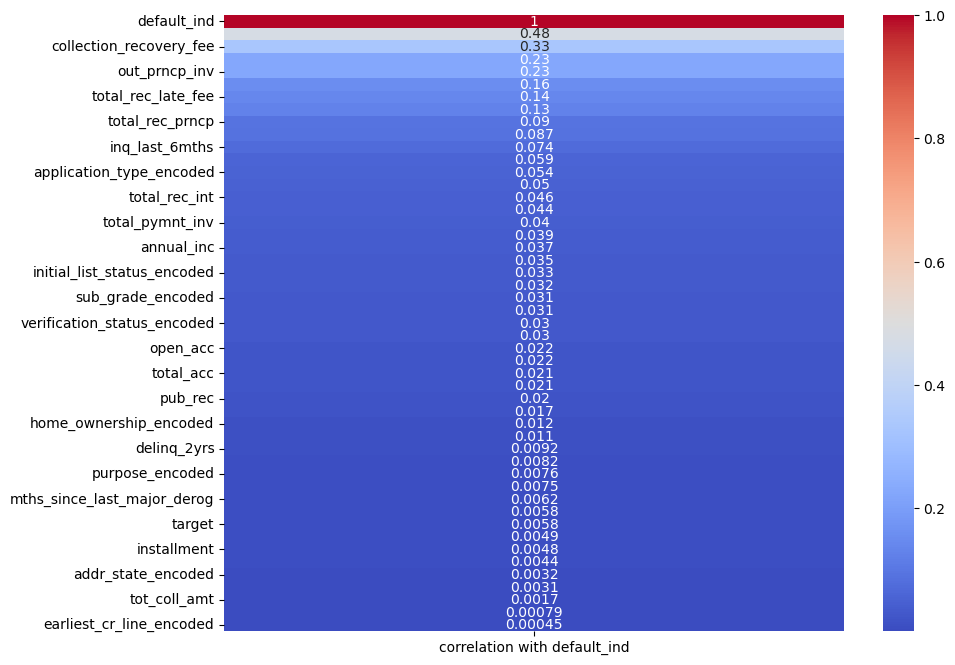

In [293]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sorted_all_corr = [(c, f) for f, c in sorted(
    all_corr.items(), key=lambda x: x[1], reverse=True)]

# convert dictionary to pandas dataframe
df = pd.DataFrame([corr[0] for corr in sorted_all_corr], [corr[1] for corr in sorted_all_corr],
                  ["correlation with default_ind"])

# plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df, cmap='coolwarm', annot=True)
plt.show()


# Training model

## Put all features into a vector Feature

In [281]:
from pyspark.ml.feature import RFormula
supervised = RFormula(formula="default_ind ~ .")
fitted_RF = supervised.fit(encoded_df)
prepared_df = fitted_RF.transform(encoded_df)
prepared_df.show(1, vertical=True)
prepared_df = prepared_df.select(["features", "label"])


-RECORD 0-------------------------------------------
 loan_amnt                   | 5000                 
 funded_amnt                 | 5000                 
 funded_amnt_inv             | 4975.0               
 int_rate                    | 10.65                
 installment                 | 162.87               
 annual_inc                  | 24000.0              
 dti                         | 27.65                
 delinq_2yrs                 | 0                    
 inq_last_6mths              | 1                    
 mths_since_last_delinq      | 34                   
 mths_since_last_record      | 70                   
 open_acc                    | 3                    
 pub_rec                     | 0                    
 revol_bal                   | 13648                
 revol_util                  | 83.7                 
 total_acc                   | 9                    
 out_prncp                   | 0.0                  
 out_prncp_inv               | 0.0            

## Model Training

## Standard Scaling

In [33]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler().setInputCol("features").setOutputCol("features_scaled")
scaler_model = scaler.fit(prepared_df)
scaler_df = scaler_model.transform(prepared_df)
pd.set_option('display.max_colwidth', 100)

scaler_df.select("features", "features_scaled").toPandas().head(5)


,features,features_scaled
0,"(5000.0, 5000.0, 4975.0, 10.65, 162.87, 24000.0, 27.65, 0.0, 1.0, 34.0, 70.0, 3.0, 0.0, 13648.0,...","(0.5934478605052874, 0.5938614922503511, 0.5904480008127682, 2.437982988375502, 0.66824801007068..."
1,"(2500.0, 2500.0, 2500.0, 15.27, 59.83, 30000.0, 1.0, 0.0, 5.0, 34.0, 70.0, 3.0, 0.0, 1687.0, 9.4...","(0.2967239302526437, 0.29693074612517556, 0.29670753809686845, 3.495586876290509, 0.245479698179..."
2,"(2400.0, 2400.0, 2400.0, 15.96, 84.33, 12252.0, 8.72, 0.0, 2.0, 34.0, 70.0, 2.0, 0.0, 2956.0, 98...","(0.284854973042538, 0.28505351628016856, 0.2848392365729937, 3.6535407037063865, 0.3460020549472..."
3,"(10000.0, 10000.0, 10000.0, 13.49, 339.31, 49200.0, 20.0, 0.0, 1.0, 35.0, 70.0, 10.0, 0.0, 5598....","(1.1868957210105748, 1.1877229845007022, 1.1868301523874738, 3.088111785275636, 1.39217309693058..."
4,"(3000.0, 3000.0, 3000.0, 12.69, 67.79, 80000.0, 17.94, 0.0, 0.0, 38.0, 70.0, 15.0, 0.0, 27783.0,...","(0.35606871630317244, 0.3563168953502107, 0.35604904571624213, 2.9049769129094014, 0.27813920674..."


In [34]:
prepared_df = scaler_df.select(["features_scaled", "label"])

prepared_df = prepared_df.withColumnRenamed('features_scaled', 'features')

In [35]:
prepared_df.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(1118,[0,1,2,3,4,...|  0.0|
|(1118,[0,1,2,3,4,...|  1.0|
|(1118,[0,1,2,3,4,...|  0.0|
|(1118,[0,1,2,3,4,...|  0.0|
|(1118,[0,1,2,3,4,...|  0.0|
|(1118,[0,1,2,3,4,...|  0.0|
|(1118,[0,1,2,3,4,...|  0.0|
|(1118,[0,1,2,3,4,...|  0.0|
|(1118,[0,1,2,3,4,...|  1.0|
|(1118,[0,1,2,3,4,...|  1.0|
|(1118,[0,1,2,3,4,...|  0.0|
|(1118,[0,1,2,3,4,...|  0.0|
|(1118,[0,1,2,3,4,...|  1.0|
|(1118,[0,1,2,3,4,...|  0.0|
|(1118,[0,1,2,3,4,...|  1.0|
|(1118,[0,1,2,3,4,...|  0.0|
|(1118,[0,1,2,3,4,...|  0.0|
|(1118,[0,1,2,3,4,...|  0.0|
|(1118,[0,1,2,3,4,...|  0.0|
|(1118,[0,1,2,3,4,...|  0.0|
+--------------------+-----+
only showing top 20 rows



By standard scaling the data, we can ensure that each feature has a similar range and variability, so that the logistic regression algorithm can treat all features equally. This can improve the performance of the algorithm and make it more accurate. 

Standard scaling can also help to reduce the effects of outliers in the data. If a feature has a very large outlier, it can skew the entire distribution of that feature and make it difficult to compare to other features. By scaling the data, the effect of outliers is reduced and the distribution of the data is more easily interpreted.

## Split Data Set

In [36]:
# Split your dataset into training and testing sets using stratified sampling
fractions = {0: 0.67, 1: 0.67}
seed = 12345
training_data = prepared_df.sampleBy("default_ind", fractions, seed)
testing_data = prepared_df.subtract(training_data)

print(f"Training data size: {training_data.count()}")

print(f"Testing data size: {testing_data.count()}")


Training data size: 572768
Testing data size: 283201


Split the data into 2/3 training and 1/3 testing

## Decision Tree Model

In [37]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxBins=35)
dt_model = dt.fit(training_data)

## Naive Bayes Model

In [38]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(featuresCol="features", labelCol="label", smoothing=1.0, modelType="multinomial")
nb_model = nb.fit(training_data)

## Logistic Regression Model

In [39]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=5)
lr_model = lr.fit(training_data)

## Evaluating model

In [165]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator


def evaluate_model(predictions, predCol="prediction", rawPredCol="rawPrediction", labelCol="label"):
    predictions = predictions.select(predCol, rawPredCol, labelCol)
    # Extract values from confusion matrix
    tp = predictions.filter((predictions.prediction == 1) & (
        predictions.label == predictions.prediction)).count()
    fp = predictions.filter((predictions.prediction == 1) & (
        predictions.label != predictions.prediction)).count()
    tn = predictions.filter((predictions.prediction == 0) & (
        predictions.label == predictions.prediction)).count()
    fn = predictions.filter((predictions.prediction == 0) & (
        predictions.label != predictions.prediction)).count()
    print("True positives (TP): ", tp)
    print("True negatives (TN): ", tn)
    print("False positives (FP): ", fp)
    print("False negatives (FN): ", fn)
    print()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2*((precision*recall)/(precision+recall))
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    print("Confusion Matrix:")
    confusion_matrix = predictions.groupBy(
        predCol).pivot(labelCol).count().na.fill(0)
    confusion_matrix.show()
    evaluator = BinaryClassificationEvaluator()
    areaUnderPR = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
    areaUnderROC = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
    confusion_matrix = predictions.groupBy(
        predCol).pivot(labelCol).count().na.fill(0)
    print(f"{'Accuracy: ':<12}{accuracy}")
    print(f"{'Precision: ':<12}{precision}")
    print(f"{'Recall: ':<12}{recall}")
    print(f"{'F1 Score: ':<12}{f1}")
    print(f"{'Area under PR curve: ':<25}{areaUnderPR}")
    print(f"{'Area under ROC curve: ':<25}{areaUnderROC}")
    return {"accuracy": accuracy,
            "precision": precision,
            "f1": f1,
            "recall": recall,
            "confusion_matrix": confusion_matrix,
            "auc_PR": areaUnderPR,
            "auc_ROC": areaUnderROC}


## Evaluating decision tree before tuning

In [166]:
# Generate predictions using decision tree model
pred_dt = dt_model.transform(testing_data)
pred_dt.show(3)

+--------------------+-----+---------------+--------------------+----------+
|            features|label|  rawPrediction|         probability|prediction|
+--------------------+-----+---------------+--------------------+----------+
|(1118,[0,1,2,3,4,...|  0.0|[402578.0,11.0]|[0.99997267684909...|       0.0|
|(1118,[0,1,2,3,4,...|  0.0|[402578.0,11.0]|[0.99997267684909...|       0.0|
|(1118,[0,1,2,3,4,...|  0.0|[402578.0,11.0]|[0.99997267684909...|       0.0|
+--------------------+-----+---------------+--------------------+----------+
only showing top 3 rows



In [167]:
# Evaluate the model
metrics_dt = evaluate_model(pred_dt)


True positives (TP):  12444
True negatives (TN):  267915
False positives (FP):  9
False negatives (FN):  2833

Confusion Matrix:
+----------+------+-----+
|prediction|   0.0|  1.0|
+----------+------+-----+
|       0.0|267915| 2833|
|       1.0|     9|12444|
+----------+------+-----+

Accuracy:   0.9899647247008309
Precision:  0.9992772825825103
Recall:     0.8145578320350855
F1 Score:   0.8975117201586729
Area under PR curve:     0.8897337301293379
Area under ROC curve:    0.9665882358037877


As our data set is very imbalanced, precision, recall and f1 scores will be very useful. 

In this case, we have alot more default_ind with value '0' than '1'. As such, a significant amount of people do not default on their loans. As such, we want to minimise false negatives, as the impact of classifying someone as a non-defaulter as a potential defaulter is higher than misclassifying someone as a defaulter as a non-defaulter. Hence, recall-score is our most important matrix when evaluating the models. As, a lower recall score means a greater false negatives which would misclassify potential defaulters as non-defaulters.

In our decision tree classifier, the recall score is 0.8145578320350855 with 2833 false negatives. 

The area under PR curve is 0.8897337301293379. We want to maximimse area under the PR curve to maximise precision-recall trade-off. 

Hence, we want to tune the model such that we have a higher recall score and less false negatives.



## Evaluating Naive Bayes before tuning

In [168]:
# Generate predictions using decision tree model
pred_nb = nb_model.transform(testing_data)
pred_nb.show(3)

# Evaluate the model
metrics_nb = evaluate_model(pred_nb)


+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(1118,[0,1,2,3,4,...|  0.0|[-926.42086338315...|[1.0,5.4495206418...|       0.0|
|(1118,[0,1,2,3,4,...|  0.0|[-851.06404663397...|[1.0,6.3321182686...|       0.0|
|(1118,[0,1,2,3,4,...|  0.0|[-857.00769221428...|[1.0,6.4090385256...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 3 rows

True positives (TP):  11147
True negatives (TN):  234150
False positives (FP):  33774
False negatives (FN):  4130

Confusion Matrix:
+----------+------+-----+
|prediction|   0.0|  1.0|
+----------+------+-----+
|       0.0|234150| 4130|
|       1.0| 33774|11147|
+----------+------+-----+

Accuracy:   0.8661586646939806
Precision:  0.24814674651054072
Recall:     0.7296589644563723
F1 Score:   0.370

In our naives bayes classifier, the recall score is 0.7296589644563723 with 4130 false negatives. 

The area under PR curve is 0.035466082549546925. We want to maximimse area under the PR curve to maximise precision-recall trade-off. 

Hence, we want to tune the model such that we have a higher recall score and less false negatives.

In this model, we observed that the precision score is very low at 0.24814674651054072. Hence, when the model predicts a positive result, it is often incorrect. The higher amount of false positives meant that the model predicted 33774 of non-defaulters as defaulters. Which will probably lead to less people getting the loan rates they deserve.

The output shows that the model has predicted label 0 for all three data points in the example. The raw prediction for each data point is a vector of two values, one for each label. The probability for each data point shows that the model is almost certain that the label is 0, with a probability of 1.0 for label 0 and very low probability for label 1.

The confusion matrix and evaluation metrics show that the model has a high accuracy of 0.87, which means that it correctly predicted 87% of the test set. However, the precision of the model is low at 0.25, indicating that out of all the predicted positives, only 25% are actually true positives. The recall of the model is relatively high at 0.73, indicating that it correctly identifies 73% of the actual positive cases. The F1 score is 0.37, which is a harmonic mean of precision and recall.

The area under the PR curve is very low at 0.035, indicating that the model is not performing well in terms of precision and recall. Similarly, the area under the ROC curve is also low at 0.31, indicating that the model's ability to distinguish between positive and negative classes is not very good.

The large number of false positives (33774) and false negatives (4130) in the confusion matrix suggests that the model may be overfitting to the training data and may need tuning to improve its performance.



## Evaluating Logistic Regression before tuning

In [169]:
# Generate predictions using decision tree model
pred_lr = lr_model.transform(testing_data)
pred_lr.show(3)

# Evaluate the model
metrics_lr = evaluate_model(pred_lr)


+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(1118,[0,1,2,3,4,...|  0.0|[4.49939374744336...|[0.98900646773646...|       0.0|
|(1118,[0,1,2,3,4,...|  0.0|[3.82454341799270...|[0.97863790073081...|       0.0|
|(1118,[0,1,2,3,4,...|  0.0|[3.45747133257558...|[0.96945317231643...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 3 rows

True positives (TP):  12274
True negatives (TN):  267891
False positives (FP):  33
False negatives (FN):  3003

Confusion Matrix:
+----------+------+-----+
|prediction|   0.0|  1.0|
+----------+------+-----+
|       0.0|267891| 3003|
|       1.0|    33|12274|
+----------+------+-----+

Accuracy:   0.9892796988711198
Precision:  0.9973185991712034
Recall:     0.8034299927996335
F1 Score:   0.8899361

In our logistic regression classifier, the recall score is 0.8034299927996335 with 3003 false negatives. 

The area under PR curve is 0.9832874593430297. We want to maximimse area under the PR curve to maximise precision-recall trade-off. 

Hence, we want to tune the model such that we have a higher recall score and less false negatives.

## Visualizing the performance of the models before tuning 

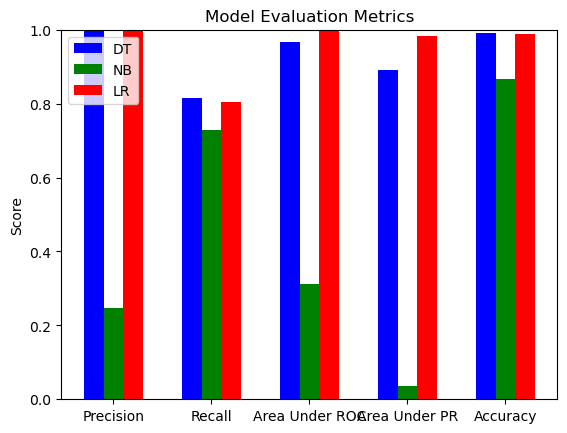

In [189]:
import matplotlib.pyplot as plt
import numpy as np

# Define the evaluation metrics and their scores
models = ['Decision Tree', 'Naive Bayes', 'Logistic Regression']
precision = [metrics_dt['precision'],
             metrics_nb['precision'], metrics_lr['precision']]
recall = [metrics_dt['recall'], metrics_nb['recall'], metrics_lr['recall']]
auc_ROC = [metrics_dt['auc_ROC'],
            metrics_nb['auc_ROC'], metrics_lr['auc_ROC']]
auc_PR = [metrics_dt['auc_PR'], metrics_nb['auc_PR'], metrics_lr['auc_PR']]
accuracy = [metrics_dt['accuracy'],
            metrics_nb['accuracy'], metrics_lr['accuracy']]

dt = [metrics_dt['precision'], metrics_dt['recall'],
      metrics_dt['auc_ROC'], metrics_dt['auc_PR'], metrics_dt['accuracy']]
nb = [metrics_nb['precision'], metrics_nb['recall'],
      metrics_nb['auc_ROC'], metrics_nb['auc_PR'], metrics_nb['accuracy']]
lr = [metrics_lr['precision'], metrics_lr['recall'],
      metrics_lr['auc_ROC'], metrics_lr['auc_PR'], metrics_lr['accuracy']]
scores = ['Precision', 'Recall', 'Area Under ROC', 'Area Under PR', 'Accuracy']

bar_width = 0.2

r1 = np.arange(len(scores))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plot the bars
plt.bar(r1, dt, color='blue', width=bar_width, label='DT')
plt.bar(r2, nb, color='green', width=bar_width, label='NB')
plt.bar(r3, lr, color='red', width=bar_width, label='LR')

# Add labels and title
plt.xticks([r + bar_width for r in range(len(scores))], scores)
plt.ylabel('Score')
plt.title('Model Evaluation Metrics')
plt.ylim([0, 1])

# Add legend
plt.legend()

# Show the plot
plt.show()


Based on the evaluation metrics, we can conclude that the decision tree classifier and logistic regression classifier outperform the naive Bayes classifier in predicting loan defaults. Both decision tree and logistic regression classifiers have higher recall scores, which means they correctly identify more actual defaulters as defaulters. The area under the PR curve for the logistic regression classifier is also significantly higher than the other two classifiers, indicating a better precision-recall trade-off.

However, all three classifiers have relatively low precision scores, which means that when the model predicts a positive result (default), it is often incorrect. This is especially true for the naive Bayes classifier, which has the lowest precision score among the three models. The high number of false positives in the naive Bayes classifier indicates that the model predicts many non-defaulters as defaulters, which can have negative consequences for loan applicants. We want to make sure that we accurately capture as accurately as possible the number of applicants who may default on their loans. Thus, our aim for the model is to increase the recall score to keep the false negatives as low as possible.

Based on the aim of having a lower false negative rate, it is recommended to further tune the decision tree and logistic regression classifiers to improve their recall scores and reduce false negatives. The area under the PR curve should also be maximized to improve the precision-recall trade-off. As, this could result in unnecessary restrictions or higher interest rates for the customer who are actually non-defaulters, which could affect their ability to obtain loans in the future. 

It is also important to consider the low precision score in the naive Bayes classifier, which indicates that the model is often incorrectly predicting a positive result. This could lead to less people getting the loan rates they deserve. Thus, it may be necessary to further evaluate and potentially adjust the decision threshold of the naive Bayes classifier.

From the graphs, we can see that the Naive Bayes Model performs the worst out of the three models in all metrics. In particular, it has a very low precision score, Area Under PR, and Area Under ROC. This indicates that the Naive Bayes Model's ability to correctly identify true positives and true negatives is poor. Naives Bayes Model in general may be biased towards the majority class (default_ind 0), leading to poor performance on the minority class (default_ind 1).

## User-defined Function

Defines a new feature by using the User-Defined Transform functionality, which implements 
a parameter to use this new feature or not in the model fine-tuning step.

In [253]:
from pyspark.sql.functions import col

UDT_df = fitted_RF.transform(encoded_df)

# User Defined Transformation to add a feature that presents the percentage of the proposed loan that was funded
def get_percentage_of_loan_funded(df, useInModel = True):
    if not useInModel:
        return df
    return df.withColumn("loan_percentage_funded", col('funded_amnt') / col('loan_amnt'))


UDT_df.show(3)

transformed_df = UDT_df.transform(get_percentage_of_loan_funded, True)
transformed_df.select("funded_amnt", "loan_amnt", "loan_percentage_funded").show(2)


+---------+-----------+---------------+--------+-----------+----------+-----+-----------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------------+---------------------------+--------------+------------+-----------+----------------+-----------+-------------+----------------------+---------------------------+----------------+------------------+---------------+------------------+------------------------+---------------------------+--------------------+--------------------+--------------------------+------------------------+------------------+-----------------+--------------------+-----+
|loan_amnt|funded_amnt|funded_amnt_inv|int_rate|installment|annual_inc|  dti|delinq_2yrs|inq_last_6mths|mths_since_last_delinq|mths_since_last_record|open_acc|pub_rec|revol_bal|r

## Model Tuning

In [190]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

def tune_model(model, param_grid, training_data, evaluator):
    param_grid_builder = ParamGridBuilder()

    for key, value in param_grid.items():
        param_grid_builder = param_grid_builder.addGrid(
            getattr(model, key), value)
    paramGrid = param_grid_builder.build()

    cv = CrossValidator(
        estimator=model, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
    cvModel = cv.fit(training_data)
    return cvModel.bestModel


### Decision Tree Tuning

In [191]:
# evaluate the Decision Tree model
dt = DecisionTreeClassifier(featuresCol='features',
                            labelCol='label', maxBins=35)
evaluator = MulticlassClassificationEvaluator(
    predictionCol="prediction", labelCol="label")
dt_tuned = tune_model(dt, {'maxDepth': [5, 10, 15], 'maxBins': [
                      20, 30, 40]}, training_data, evaluator)
pred_dt_tuned = dt_tuned.transform(testing_data)

In [193]:
# Evaluate tuned descision tree
metrics_dt_tuned = evaluate_model(pred_dt_tuned)

True positives (TP):  15019
True negatives (TN):  267869
False positives (FP):  55
False negatives (FN):  258

Confusion Matrix:
+----------+------+-----+
|prediction|   0.0|  1.0|
+----------+------+-----+
|       0.0|267869|  258|
|       1.0|    55|15019|
+----------+------+-----+

Accuracy:   0.9988947779139198
Precision:  0.9963513334217858
Recall:     0.9831118675132552
F1 Score:   0.989687324964581
Area under PR curve:     0.9823646181585236
Area under ROC curve:    0.994545186251498


We tuned the hyperparameter maxDepth and maxBins using grid search through ParamGridBuilder and CrossValidator to find the optimal depth and number of bins.

In our tuned decision tree classifier, the recall score (0.9831118675132552) is higher compared to before (0.8145578320350855).
There are also much less False Negatives (258) compared to before (2833).

The area under PR curve is also higher (0.9823646181585236) compared to before (0.8897337301293379). Henced, we maximised area under the PR curve to maximise precision-recall trade-off. 

After tuning, we have a much higher recall score and a lot less false negatives.

The model is also better at correctly identifying true positives and true negatives with a higher Area under ROC curve (0.994545186251498) than before (0.9665882358037877).

### Naive Bayes Tuning

In [194]:
# evaluate the Naive Bayes model
nb = NaiveBayes(featuresCol='features', labelCol='label')
nb_tuned = tune_model(
    nb, {'smoothing': [0.0, 0.5, 1.0]}, training_data, evaluator)
pred_nb_tuned = nb_tuned.transform(testing_data)

In [195]:
# Evaluate the tuned Naive Bayes Model
metrics_nb_tuned = evaluate_model(pred_nb_tuned)

True positives (TP):  11207
True negatives (TN):  234184
False positives (FP):  33740
False negatives (FN):  4070

Confusion Matrix:
+----------+------+-----+
|prediction|   0.0|  1.0|
+----------+------+-----+
|       0.0|234184| 4070|
|       1.0| 33740|11207|
+----------+------+-----+

Accuracy:   0.8664905844259024
Precision:  0.249338109328765
Recall:     0.7335864371277083
F1 Score:   0.3721772051009564
Area under PR curve:     0.041806319771422046
Area under ROC curve:    0.42109054742380936


We tuned the hyperparameter smoothing (laplace smoothing alpha) using grid search through ParamGridBuilder and CrossValidator to find the optimal smoothing parameter.

In our tuned naive bayes classifier, the recall score (0.7335864371277083) is higher compared to before (0.7296589644563723).
There are also less False Negatives (4070) compared to before (4130).

The area under PR curve is also higher (0.041806319771422046) compared to before (0.035466082549546925). Henced, we maximised area under the PR curve to maximise precision-recall trade-off. 

After tuning, we have a higher recall score and less false negatives.

The model is also better at correctly identifying true positives and true negatives with a higher Area under ROC curve (0.42109054742380936) than before (0.31250248816601933).

### Logistic Regression Tuning 

In [198]:
# evaluate the Logistic Regression model
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=5)
lr_tuned = tune_model(lr, {'regParam': np.arange(0, .1, .01), 'elasticNetParam': [
                      0.0, 0.5, 1.0]}, training_data, evaluator)
pred_lr_tuned = lr_tuned.transform(testing_data)

In [199]:
# evaluate the tuned Logistic regression model
metrics_lr_tuned = evaluate_model(pred_lr_tuned)

True positives (TP):  12274
True negatives (TN):  267891
False positives (FP):  33
False negatives (FN):  3003

Confusion Matrix:
+----------+------+-----+
|prediction|   0.0|  1.0|
+----------+------+-----+
|       0.0|267891| 3003|
|       1.0|    33|12274|
+----------+------+-----+

Accuracy:   0.9892796988711198
Precision:  0.9973185991712034
Recall:     0.8034299927996335
F1 Score:   0.8899361948955916
Area under PR curve:     0.9832929572724014
Area under ROC curve:    0.9974598042713388


We tuned the hyperparameter regParam and ticNetParam using gri grid search through ParamGridBuilder andssValidator to find the optimal deptregParam number of binselasticNetParam
In our tuned logistic regression classifier, the recall score (0.8034299927996335) is the same as before.
There is also the same amount of False Negatives (3003) as before.

The area under PR curve is also the same as before (0.9832874593430297).

The model is also the same at correctly identifying true positives and true negatives with the same Area under ROC curve as before (0.9974604813906285).elasticNetParam

# Evaluate the model after tuning
acc = evaluator.evaluate(pred_lr_tuned)
print("Prediction Accuracy after tuning: ", acc)

y_pred = pred_lr_tuned.select("prediction", "label").collect()
y_orig = pred_lr_tuned.select().collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix after tuning :")
print(cm)


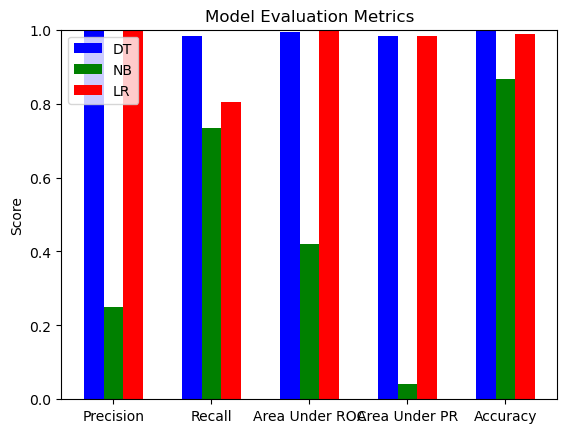

In [211]:
import matplotlib.pyplot as plt
import numpy as np

# Define the evaluation metrics and their scores
models = ['Decision Tree', 'Naive Bayes', 'Logistic Regression']
precision = [metrics_dt_tuned['precision'],
             metrics_nb_tuned['precision'], metrics_lr_tuned['precision']]
recall = [metrics_dt_tuned['recall'], metrics_nb_tuned['recall'], metrics_lr_tuned['recall']]
auc_ROC = [metrics_dt_tuned['auc_ROC'],
           metrics_nb_tuned['auc_ROC'], metrics_lr_tuned['auc_ROC']]
auc_PR = [metrics_dt_tuned['auc_PR'], metrics_nb_tuned['auc_PR'], metrics_lr_tuned['auc_PR']]
accuracy = [metrics_dt_tuned['accuracy'],
            metrics_nb_tuned['accuracy'], metrics_lr_tuned['accuracy']]

dt = [metrics_dt_tuned['precision'], metrics_dt_tuned['recall'],
      metrics_dt_tuned['auc_ROC'], metrics_dt_tuned['auc_PR'], metrics_dt_tuned['accuracy']]
nb = [metrics_nb_tuned['precision'], metrics_nb_tuned['recall'],
      metrics_nb_tuned['auc_ROC'], metrics_nb_tuned['auc_PR'], metrics_nb_tuned['accuracy']]
lr = [metrics_lr_tuned['precision'], metrics_lr_tuned['recall'],
      metrics_lr_tuned['auc_ROC'], metrics_lr_tuned['auc_PR'], metrics_lr_tuned['accuracy']]
scores = ['Precision', 'Recall', 'Area Under ROC', 'Area Under PR', 'Accuracy']

bar_width = 0.2

r1 = np.arange(len(scores))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plot the bars
plt.bar(r1, dt, color='blue', width=bar_width, label='DT')
plt.bar(r2, nb, color='green', width=bar_width, label='NB')
plt.bar(r3, lr, color='red', width=bar_width, label='LR')

# Add labels and title
plt.xticks([r + bar_width for r in range(len(scores))], scores)
plt.ylabel('Score')
plt.title('Model Evaluation Metrics')
plt.ylim([0, 1])

# Add legend
plt.legend()

# Show the plot
plt.show()


For the decision tree classifier, after tuning, the recall score increased significantly, and the number of false negatives decreased. The area under the PR curve also increased, indicating better precision-recall trade-off. The model's ability to identify true positives and true negatives also improved, as indicated by the higher Area under ROC curve.

For the naive Bayes classifier, after tuning, the recall score increased slightly, and the number of false negatives decreased. The area under the PR curve also increased, indicating better precision-recall trade-off. The model's ability to identify true positives and true negatives also improved, as indicated by the higher Area under ROC curve.

For the logistic regression classifier, after tuning, there was no improvement in recall score or false negatives. The area under the PR curve remained the same, and the model's ability to identify true positives and true negatives remained unchanged, as indicated by the same Area under ROC curve.

Overall, the process of hyperparameter tuning is crucial to optimize the performance of machine learning models. The results indicate that tuning can significantly improve the performance of some classifiers, while having little impact on others. Therefore, it is essential to conduct hyperparameter tuning for each model to identify the optimal hyperparameters.

In [ ]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        for row in rdd.collect():
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

### ROC Curve for Decision Tree Classifier after tuning
The model is extremely close to the top left corner of the plot, it indicates that the model has very high true positive rate (TPR) and low false positive rate (FPR), which is a good thing.

It suggests that the model is doing a good job in distinguishing between the positive and negative samples and has a high level of accuracy.

PythonRDD[37091] at RDD at PythonRDD.scala:53


c:\Users\Vokur\anaconda3\lib\site-packages\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


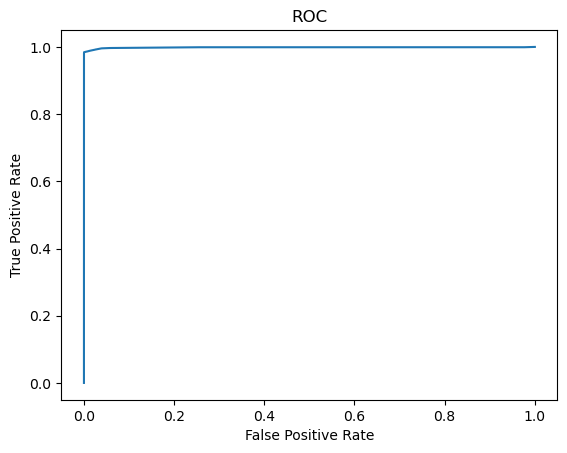

In [200]:
import matplotlib.pyplot as plt

preds_dt = pred_dt_tuned.select('label', 'probability').rdd.map(
    lambda row: (float(row['probability'][1]), float(row['label'])))

# Returns as a list (false positive rate, true positive rate)
points = CurveMetrics(preds_dt).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title("ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(x_val, y_val)


### ROC Curve for Naive Bayes Tree Classifier after tuning
The model is relatively close to the top left corner of the plot, it indicates that the model has a decent performance in terms of distinguishing between positive and negative samples.

It also suggests that, the model has a high TPR and a low FPR, which is a good indication of its performance. 

c:\Users\Vokur\anaconda3\lib\site-packages\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


283201
1013


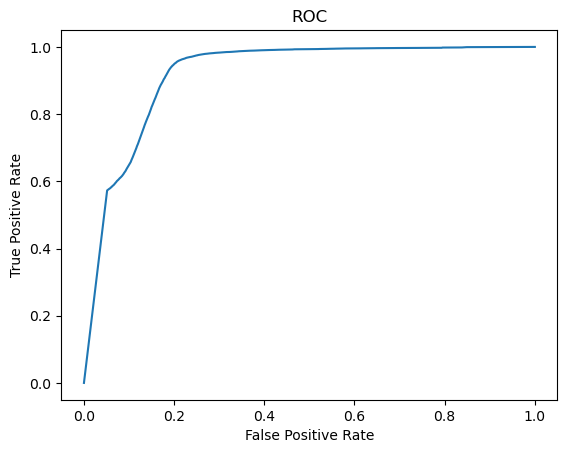

In [208]:
import matplotlib.pyplot as plt

preds_nb = pred_nb_tuned.select('label', 'probability').rdd.map(
    lambda row: (float(row['probability'][1]), float(row['label'])))

# Returns as a list (false positive rate, true positive rate)
points = CurveMetrics(preds_nb).get_curve('roc')
pprint(len(preds_nb.collect()))
pprint(len(points))

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title("ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(x_val, y_val)


### ROC Curve for Logistic Regression Classifier after tuning

Has similar performance as compared to Decision Tree, both models have high true positive rates and low false positive rates. This is a good sign, as it indicates that both models are performing well in correctly identifying positive instances.


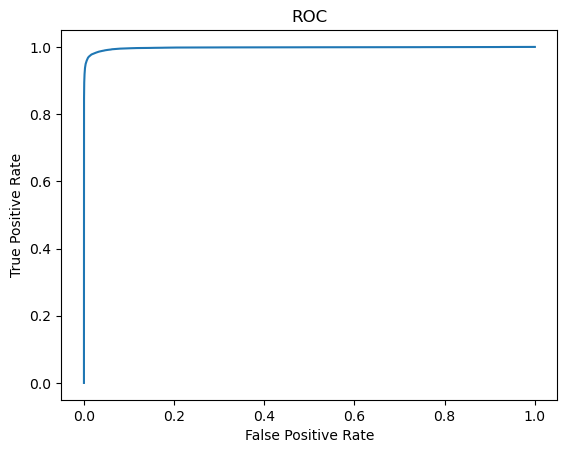

In [202]:
import matplotlib.pyplot as plt

preds_lr = pred_lr_tuned.select('label', 'probability').rdd.map(
    lambda row: (float(row['probability'][1]), float(row['label'])))

# Returns as a list (false positive rate, true positive rate)
points = CurveMetrics(preds_lr).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title("ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(x_val, y_val)


### Conclusion for ROC analysis

As the ROC curve is close to the top left corner of the plot, it indicates that the models (Decision Tree, Naive Bayes, and Logistic Regression) have a very high true positive rate and a very low false positive rate. This means that these models have a high ability to correctly identify the positive cases (i.e., high recall score) while keeping the number of false negatives (i.e., missed positive cases) low.

Therefore, based on this result, we can conclude that these models are performing well in terms of the objective of the task, which is to have a higher recall score and fewer false negatives. 

### Pyspark pros and cons

Pyspark Cons:
Limited api functionality compared to scala
Inconsistent metrics between MulticlassClassificationEvaluator and BinaryClassificationEvaluator
More difficult to derive metrics as compared to scikit learn
Lack of ability to alter dataframe in place
Does not work well with seaborn and matplotlib
Worse documentation

Pyspark Pros
Better performance
One hot encoding does not create a lot of new columns, rather, it generates a vector to store within the encoded column
